In [1]:
%load_ext autoreload
%autoreload 2
#This code is for a SSH 1D CROW network.

In [2]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure
import math as m
from segment import Segment
from func import *
import matplotlib.ticker as ticker

In [3]:
# NUM_PORTS = 4
SIZE = 100
imp0 = 377
xs0 = 50  # source position for the segment 0
kappa = [1j*0.17, 1j*0.19] #resonator-waveguide and resonator-resonator couplings
# tau = 1j* np.sqrt(1-np.abs(kappa)**2) # not working yet for complex number
# print(kappa)
maxTime = 170000

rings_no = 4   #out of N rings defined, 2 will be the input and output port (the first segment will have the source as the only connection; the last segment is redundant, the second last segment will act as the drop port.)
N_seg = rings_no*2

sources = Sources(rings_no)  #working for any number of rings
couplings = Couplings_1(rings_no, kappa)
print(sources)
print(couplings)

ez_tab = np.zeros([N_seg, maxTime, SIZE], dtype=complex)

[[-1 -1]
 [ 0  3]
 [ 3  0]
 [ 2  5]
 [ 5  2]
 [ 4  7]
 [ 7  4]
 [-2 -2]]
[[0.98544406+0.j   0.        +0.17j]
 [0.98544406+0.j   0.        +0.17j]
 [0.98178409+0.j   0.        +0.19j]
 [0.98178409+0.j   0.        +0.19j]
 [0.98178409+0.j   0.        +0.19j]
 [0.98178409+0.j   0.        +0.19j]
 [0.98544406+0.j   0.        +0.17j]
 [0.98544406+0.j   0.        +0.17j]]


In [4]:
points_per_lambda = 50
c = 2.99792e8 #m/s
f0= 200e12 #200 THz
# lambda0 = 500e-9 #500nm in the optical range
lambda0 = c/f0 #carrier frequency (resoanant frequency)
print(lambda0 * 1e9) #~1498 nm in the optical range(used in applications)
del_x = lambda0/points_per_lambda #spatial step (want 20 grid points per wavelength)
S = 0.99 #Courant number
del_t = (S * del_x)/c

N_space = SIZE #spatial domain length
L = del_x * (N_space - 1) #total spatial length 

N_time = maxTime #temporal domain length
T_total = N_time * del_t #total simulated time

N_cycle = T_total * f0 #total number of cycles

Nyq = 1/(2*f0) #Nyquist number (del_t must be smaller than this for proper sampling)

if del_t < Nyq:
    print("Possible")
    s2 = []
    for qTime in range(maxTime):
        signal = cw2(qTime, del_t, f0)
        s2.append(signal)
        
print(del_t)
print(f0*1e-12) #in THz

1498.9599999999998
Possible
9.9e-17
200.0


c:\Users\MITALI\anaconda3\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MITALI\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


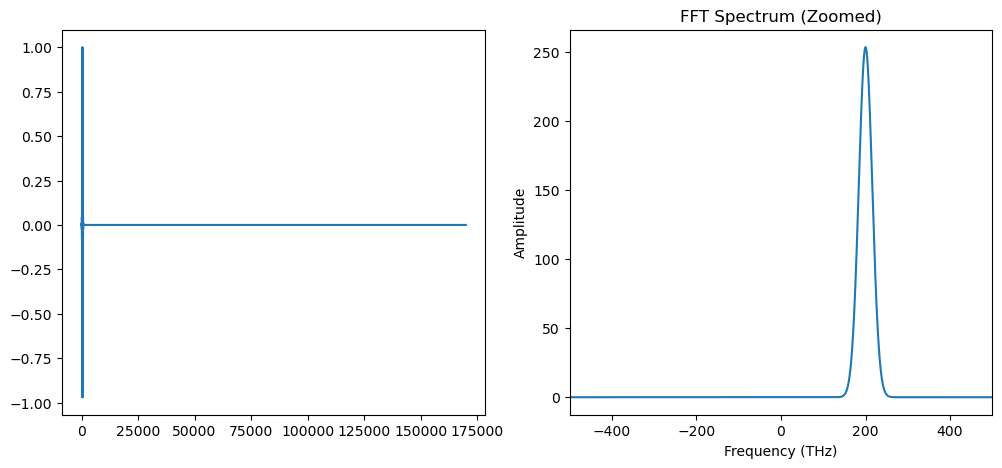

In [5]:
s3 = []
for qTime in range(maxTime):
    d = cosMod(qTime=qTime, complex_signal=True, f0=f0, del_t=del_t)
    s3.append(d)

s3 = np.array(s3)

# FFT
fft_vals = np.fft.fft(s3)
N = len(s3)
freqs = np.fft.fftfreq(N, del_t)

# Shift for visualization
fft_shift = np.abs(np.fft.fftshift(fft_vals))
freqs_shift = np.fft.fftshift(freqs)

# Plot

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot((s3))
plt.subplot(1,2,2)
plt.plot(freqs_shift/1e12, np.abs(fft_shift))
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("FFT Spectrum (Zoomed)")
plt.xlim(-500, 500)   # zoom to ±500 THz
plt.show()


In [6]:
#Printing input signals
# gauss = []
# cont = []
# print(range(maxTime))

# for qTime in range(maxTime):
#     g = gaussian(qTime, maxTime)
#     print(g)
#     conti = cw(qTime)
#     gauss.append(g)
#     cont.append(conti)
# print(np.shape(gauss))
# print(gauss)


# if del_t < Nyq:
#     print("Possible")
#     s2 = []
#     for qTime in range(maxTime):
#         signal = cw2(qTime, del_t, f0)
#         s2.append(signal)
#     figure(figsize=(20,10), dpi=80)
#     plt.subplot(1,2,1)
#     plt.plot(s2)

# fft_vals = np.abs(np.fft.fft(gauss))
# N = len(gauss)
# freqs = np.fft.fftfreq(N, d = del_t)
# plt.subplot(1,2,1)
# plt.plot(gauss)
# plt.subplot(1,2,2)
# plt.plot(freqs, np.abs(fft_vals))

# plt.show()
# plt.subplot(2,1,2)

# plt.plot(cont)
# plt.show()




In [7]:
f_array = []

s_tab = np.zeros(maxTime, dtype=complex)

for ii in range(N_seg):
    f = Segment(SIZE)
    f_array.append(f)
# print(f_array)

# lambda0 = 500e-9 
# f_center = 3e8/lambda0
# sigma_pulse = 3e-15 

# print("freq. Hz", f_center) 


for qTime in range(maxTime):
    s = cosMod(qTime, complex_signal=True, f0=f0, del_t=del_t) 
    s_tab[qTime] = s
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
        
        xs = xs0
        if (sources[ii][0] == -1):
            s_new = s   
            xs = xs0
        elif (sources[ii][0] == -2):
            s_new = 0. 
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2  
            
        # print(s_new)
        
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)
        

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"data/ez_tab_ssh{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

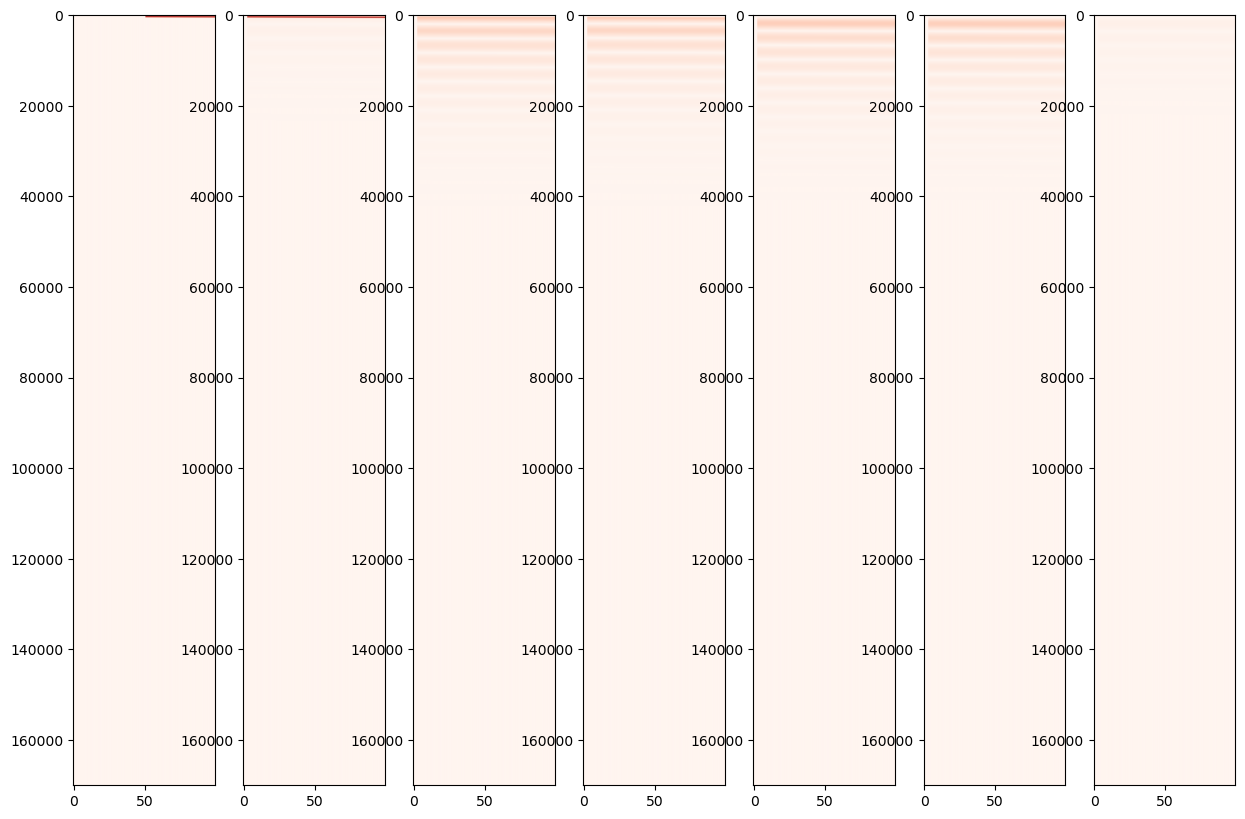

In [8]:
f, ax = plt.subplots(1,N_seg-1, figsize=(15,10)) 

vmax_val = np.max(np.real(ez_tab[0,:,:]))

for ii in range(N_seg-1):
    ax[ii].imshow(np.abs(ez_tab[ii,:,:]), aspect='auto', vmin = 0, vmax = vmax_val , cmap = 'Reds')

In [9]:

Ez = np.zeros((maxTime-1,N_seg), dtype=complex)
# yf = np.zeros((maxTime-1,N_seg), dtype=complex)
windowed_signal = np.zeros((maxTime-1,N_seg), dtype=complex)
spectrum = np.zeros((maxTime-1, N_seg), dtype=complex)


for ii in range(N_seg):
    filename = f"data/ez_tab_ssh{ii:04d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    Ez[:,ii] = df.iloc[:,60]   #all rows of the 10th spatial point
   
    Ez[:,ii] -= np.mean(Ez[:,ii])
    
    spectrum[:,ii] = np.fft.fft(Ez[:,ii])
    
    # yf[:,ii] = np.abs(np.fft.fft(Ez[:,ii]))
    # dt = 1e-15    # your time step [s] (adjust to your simulation)

    # Apply Hann window
    # Ez[:,ii] = Ez[:,ii] - np.mean(Ez[:,ii])  #subtracting the average
    # window = np.hanning(N)
    # windowed_signal[:,ii] = Ez[:,ii] * window
    
    # fft_vals = np.fft.fft(windowed_signal[:,ii])
    # fft_vals = fft_vals / N #normalising by the number of samples
    # spectrum[:, ii] = fft_vals   # store in column
N = len(Ez[:,0])
freqs = np.fft.fftfreq(N, del_t)
mask = freqs >= 0
freqs = freqs[mask]
spectrum = np.abs(spectrum[mask,:])





# Plot
# for ii in range(N_seg - 1):
#     plt.plot(freqs, spectrum)
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Amplitude")
#     plt.title("FFT with Hann Window")
#     plt.show()


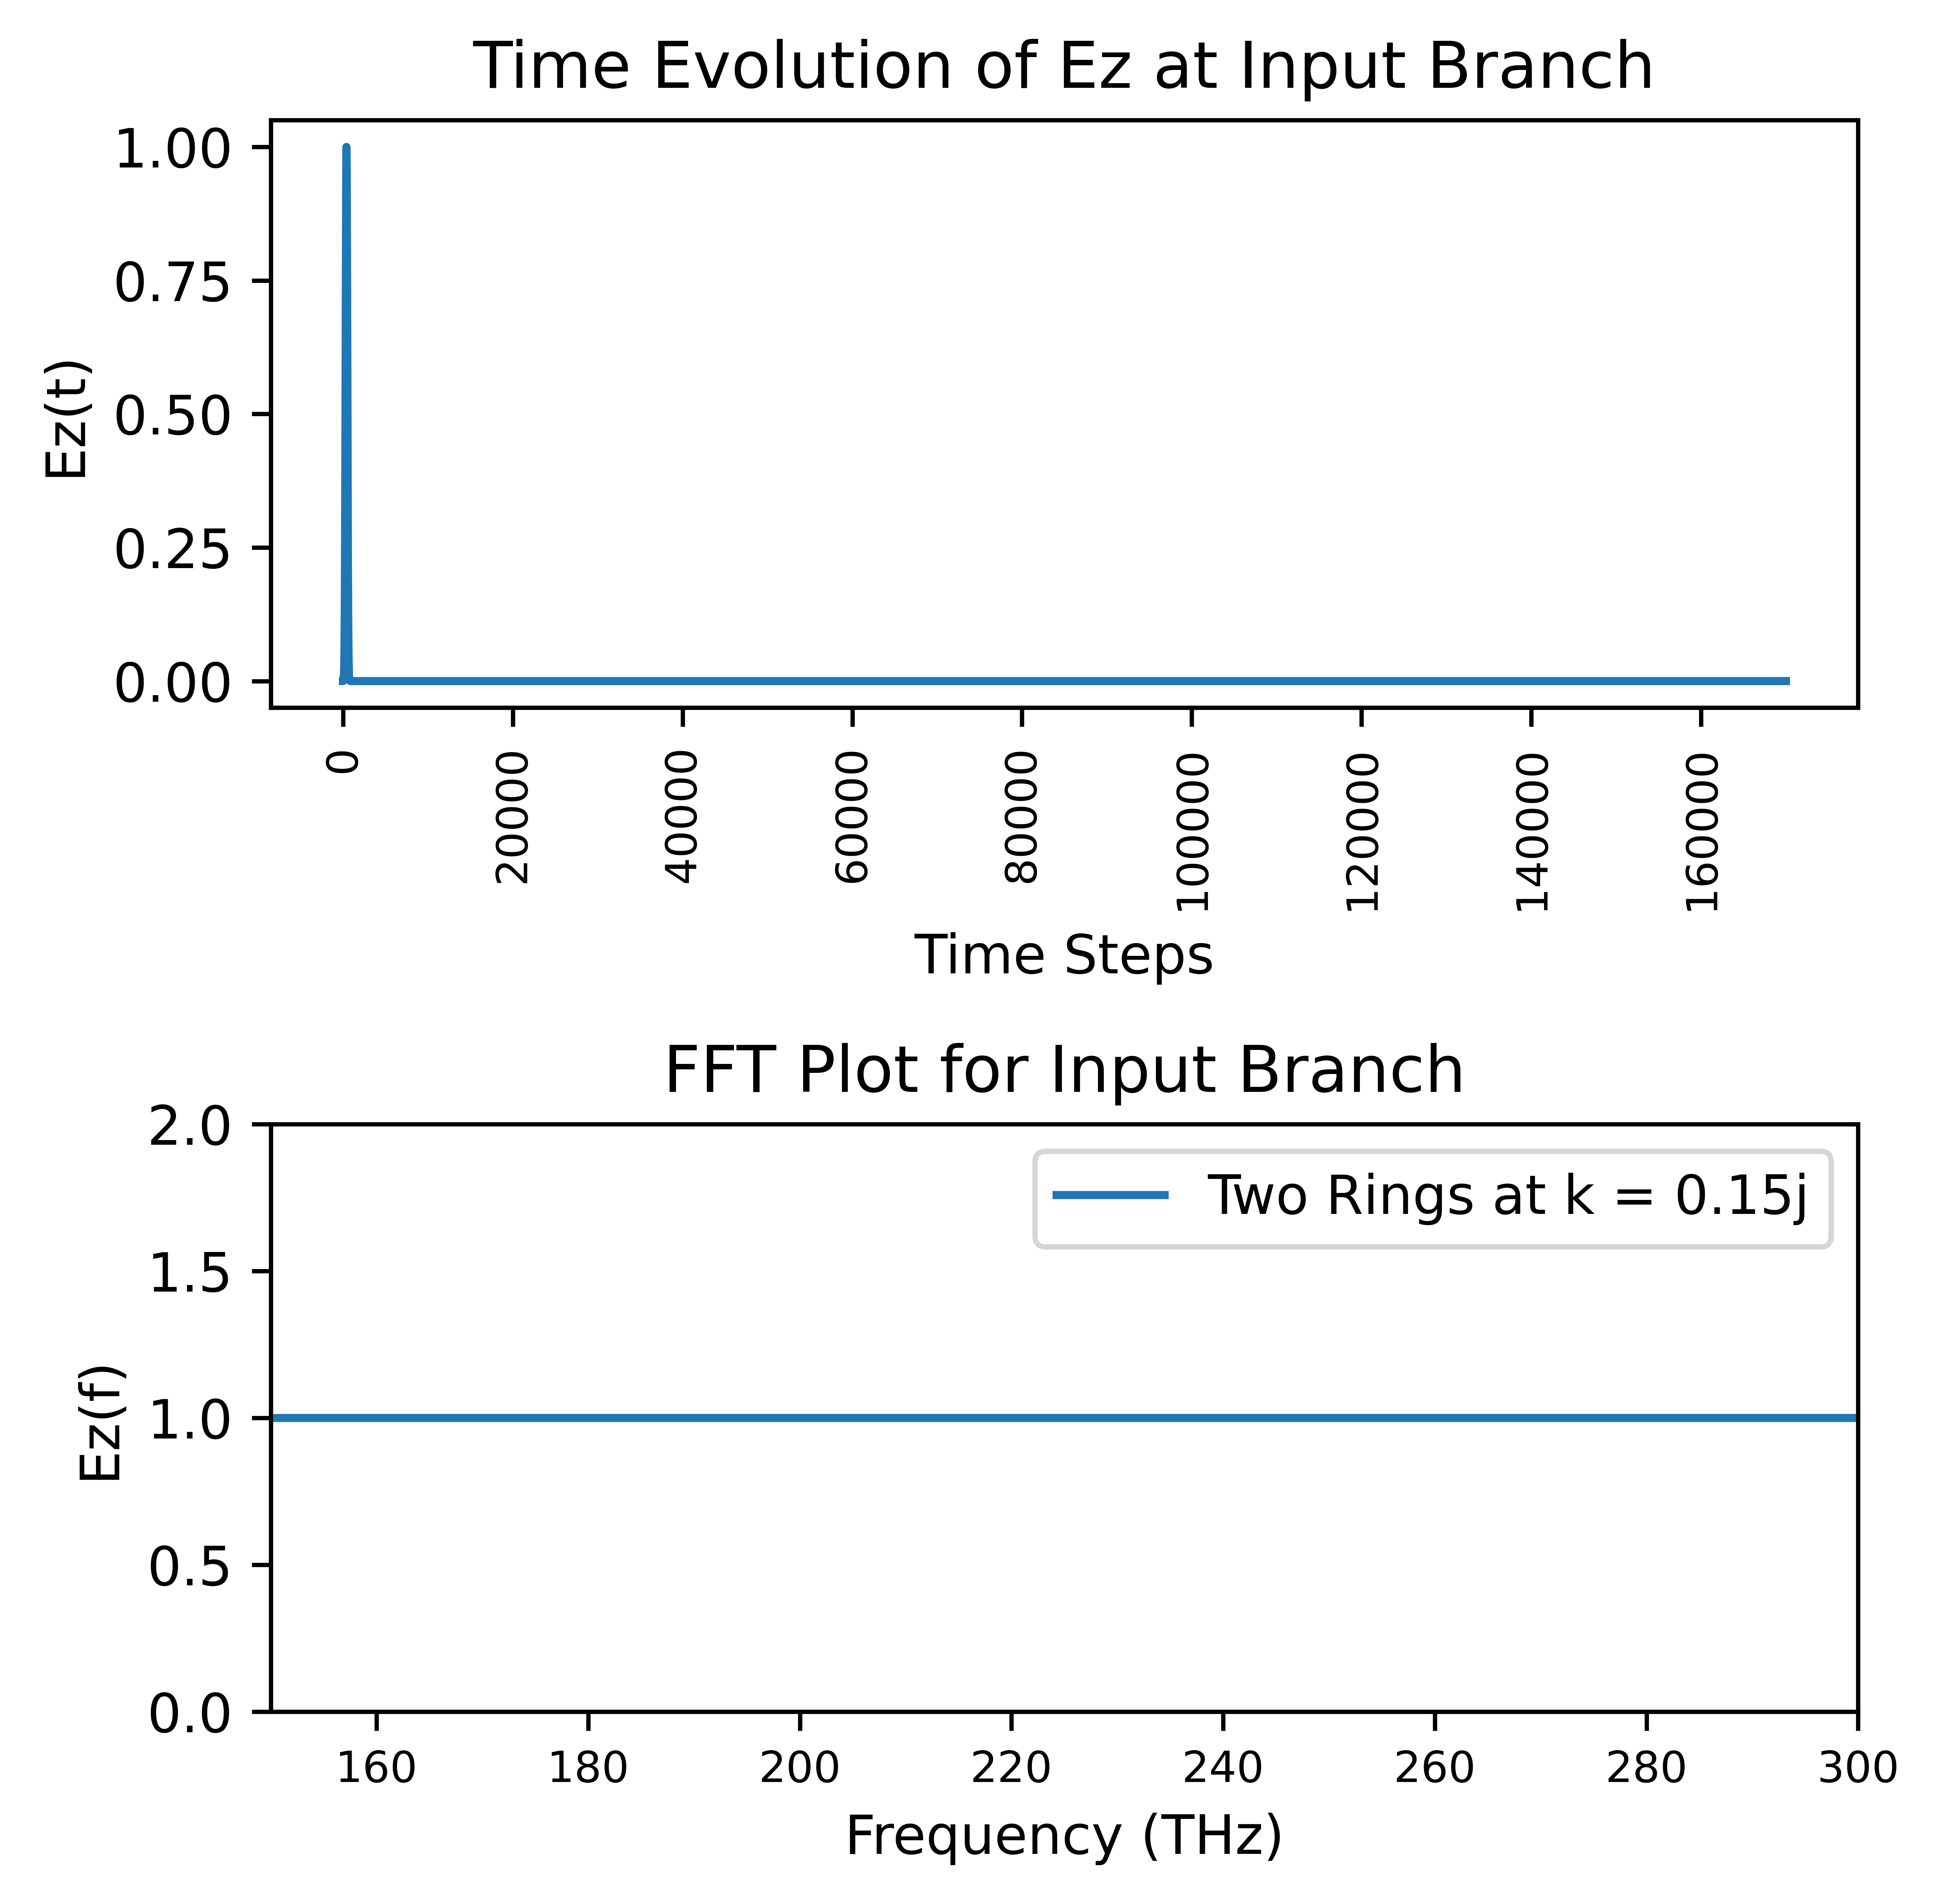

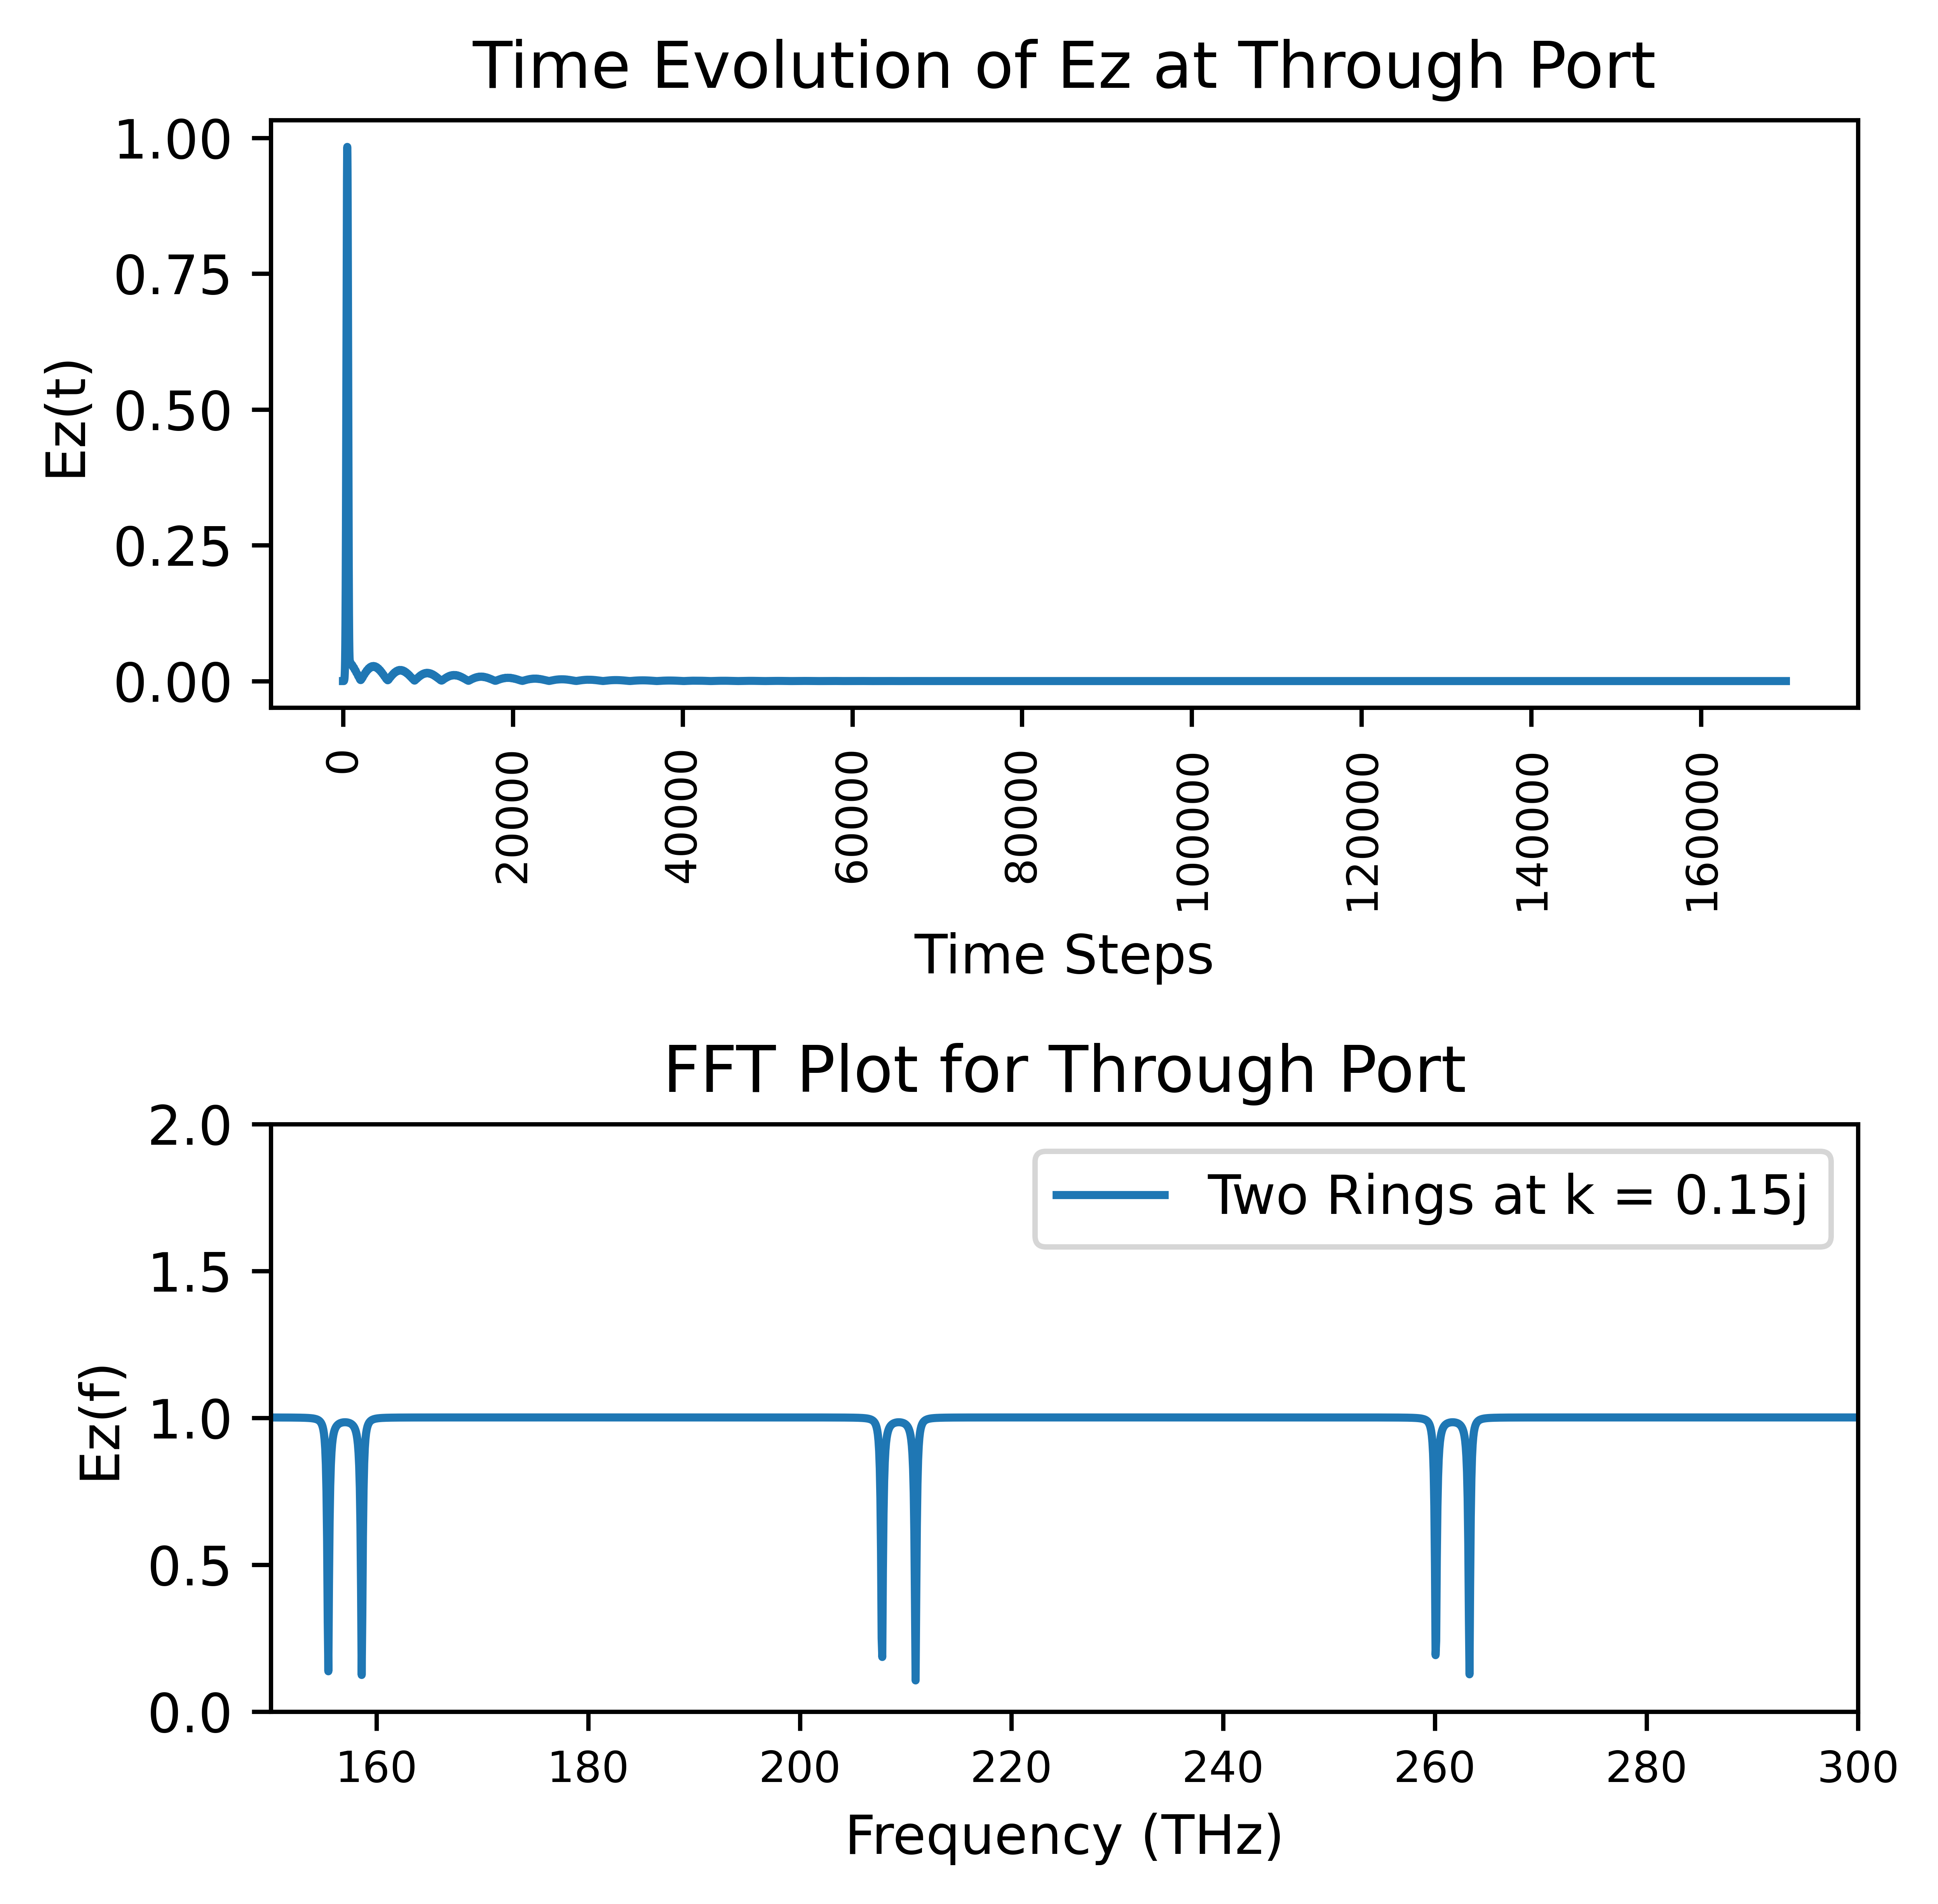

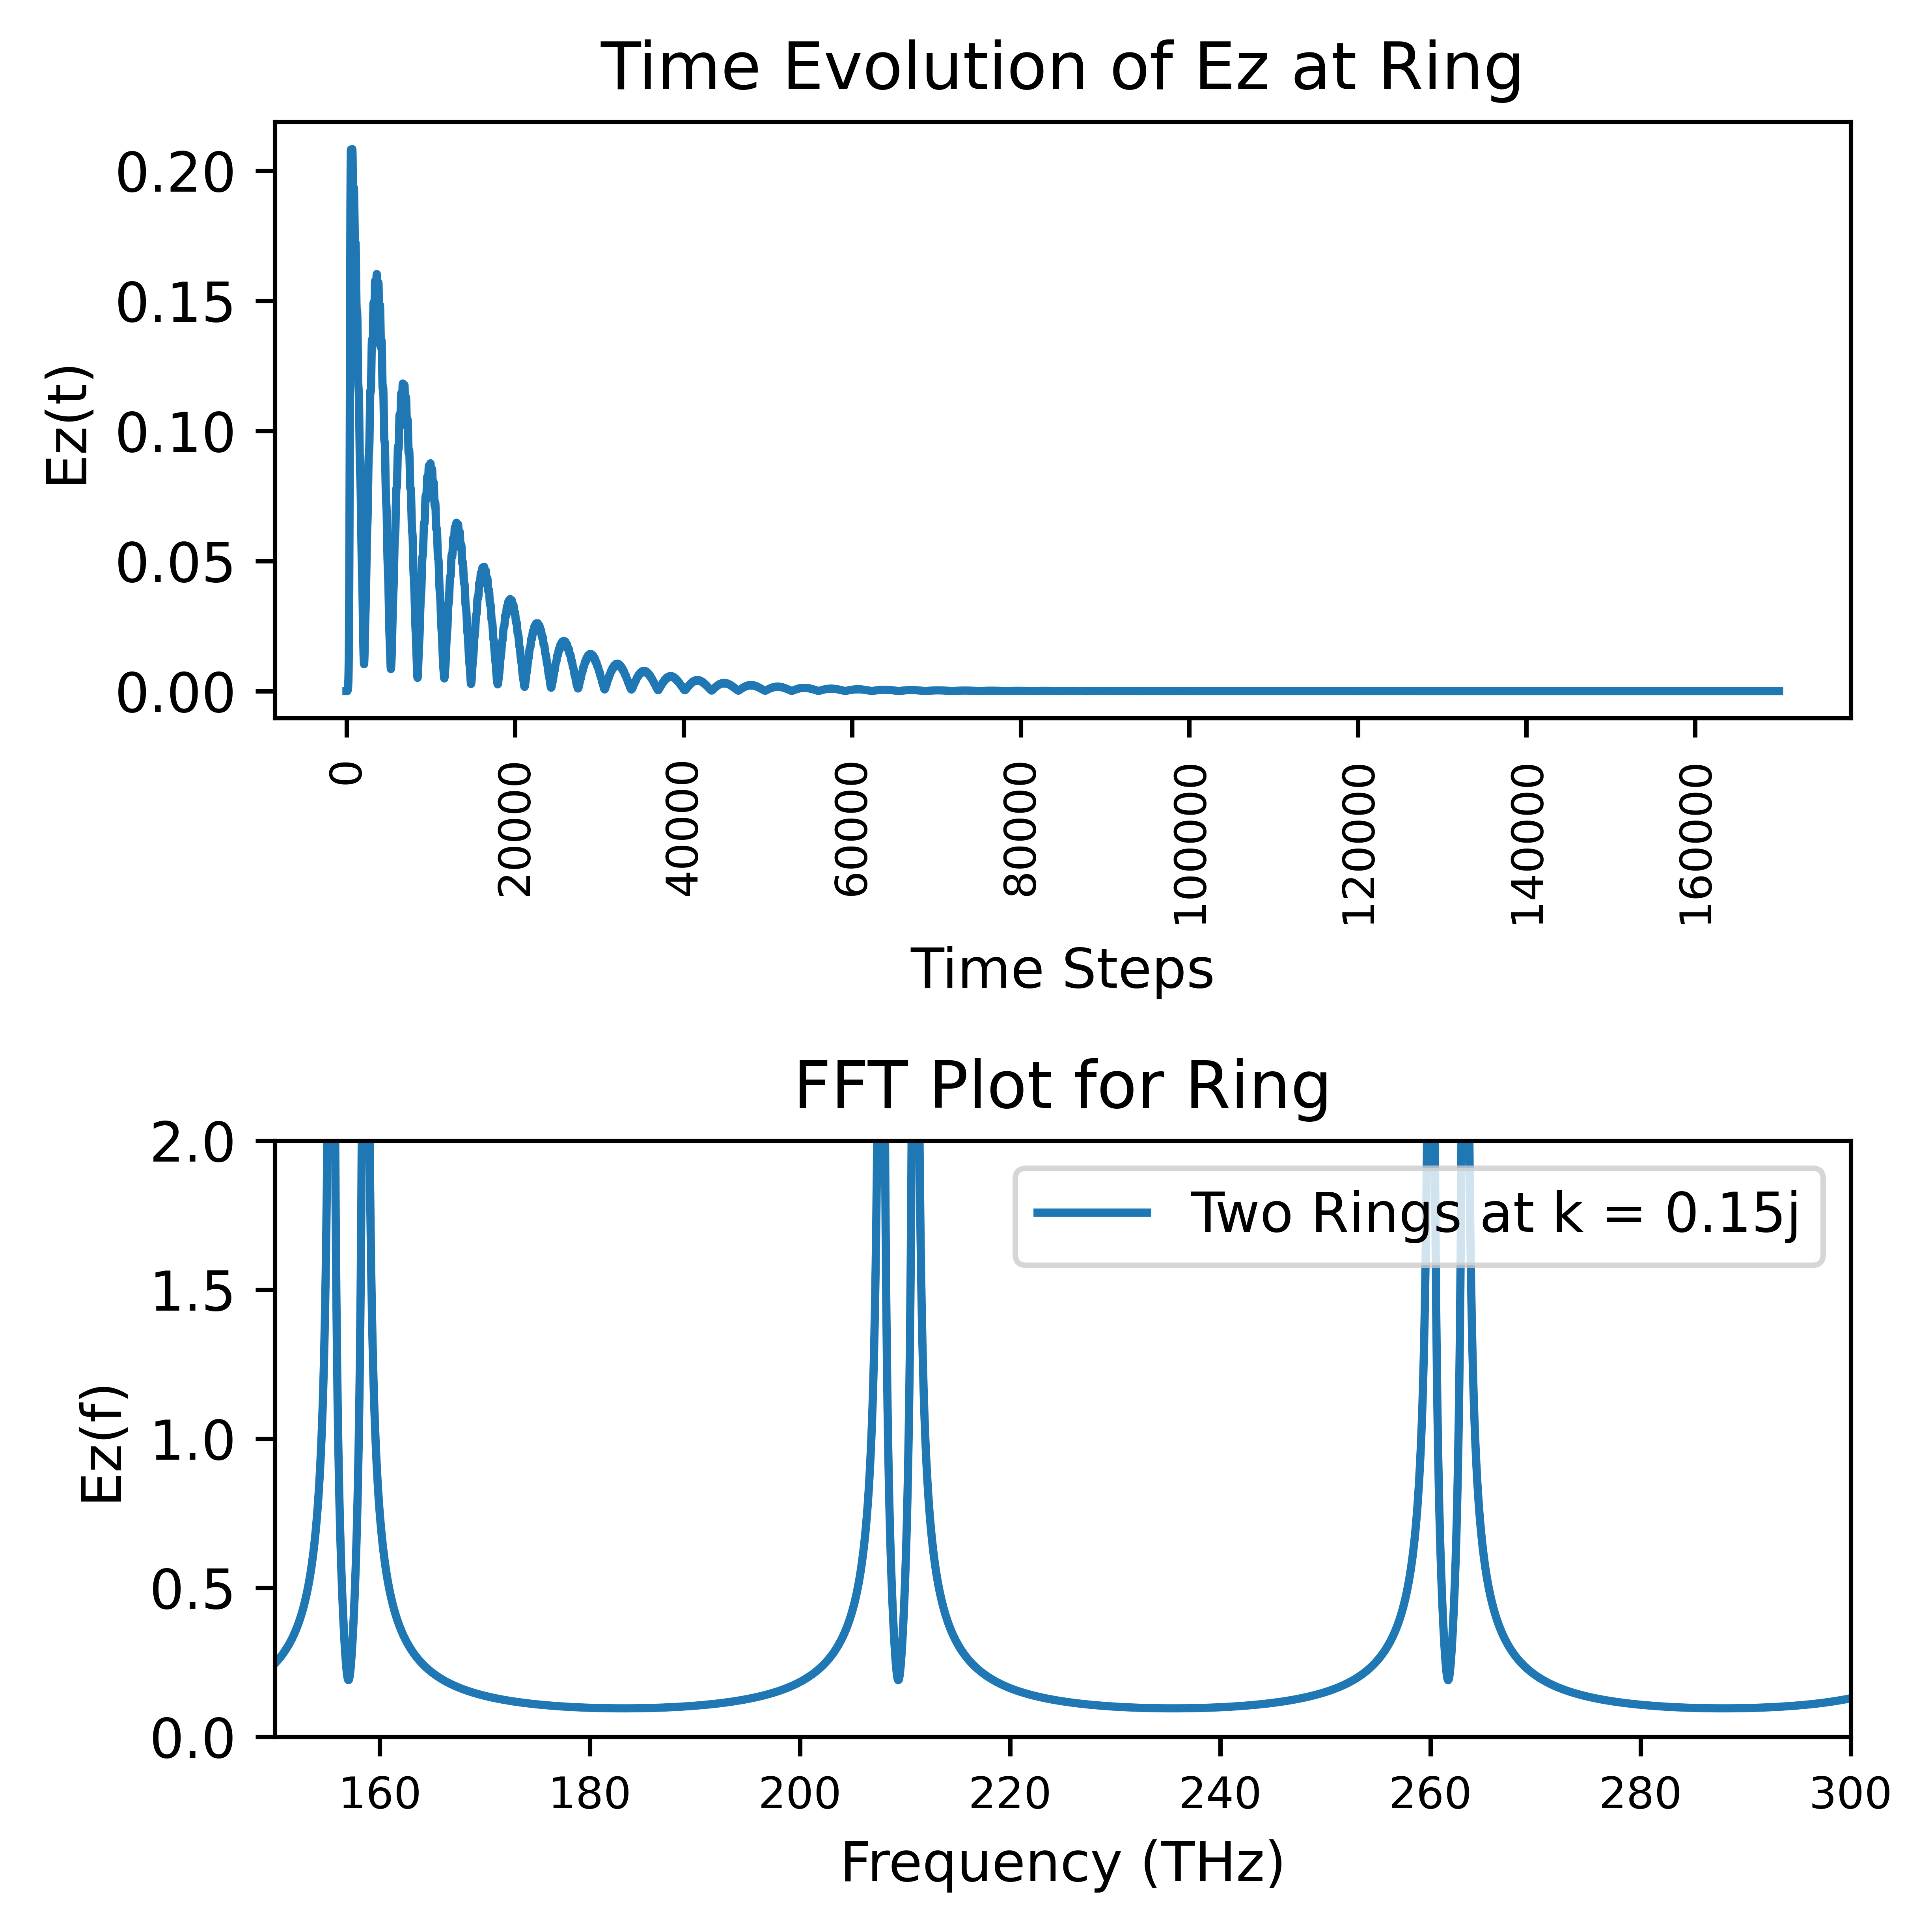

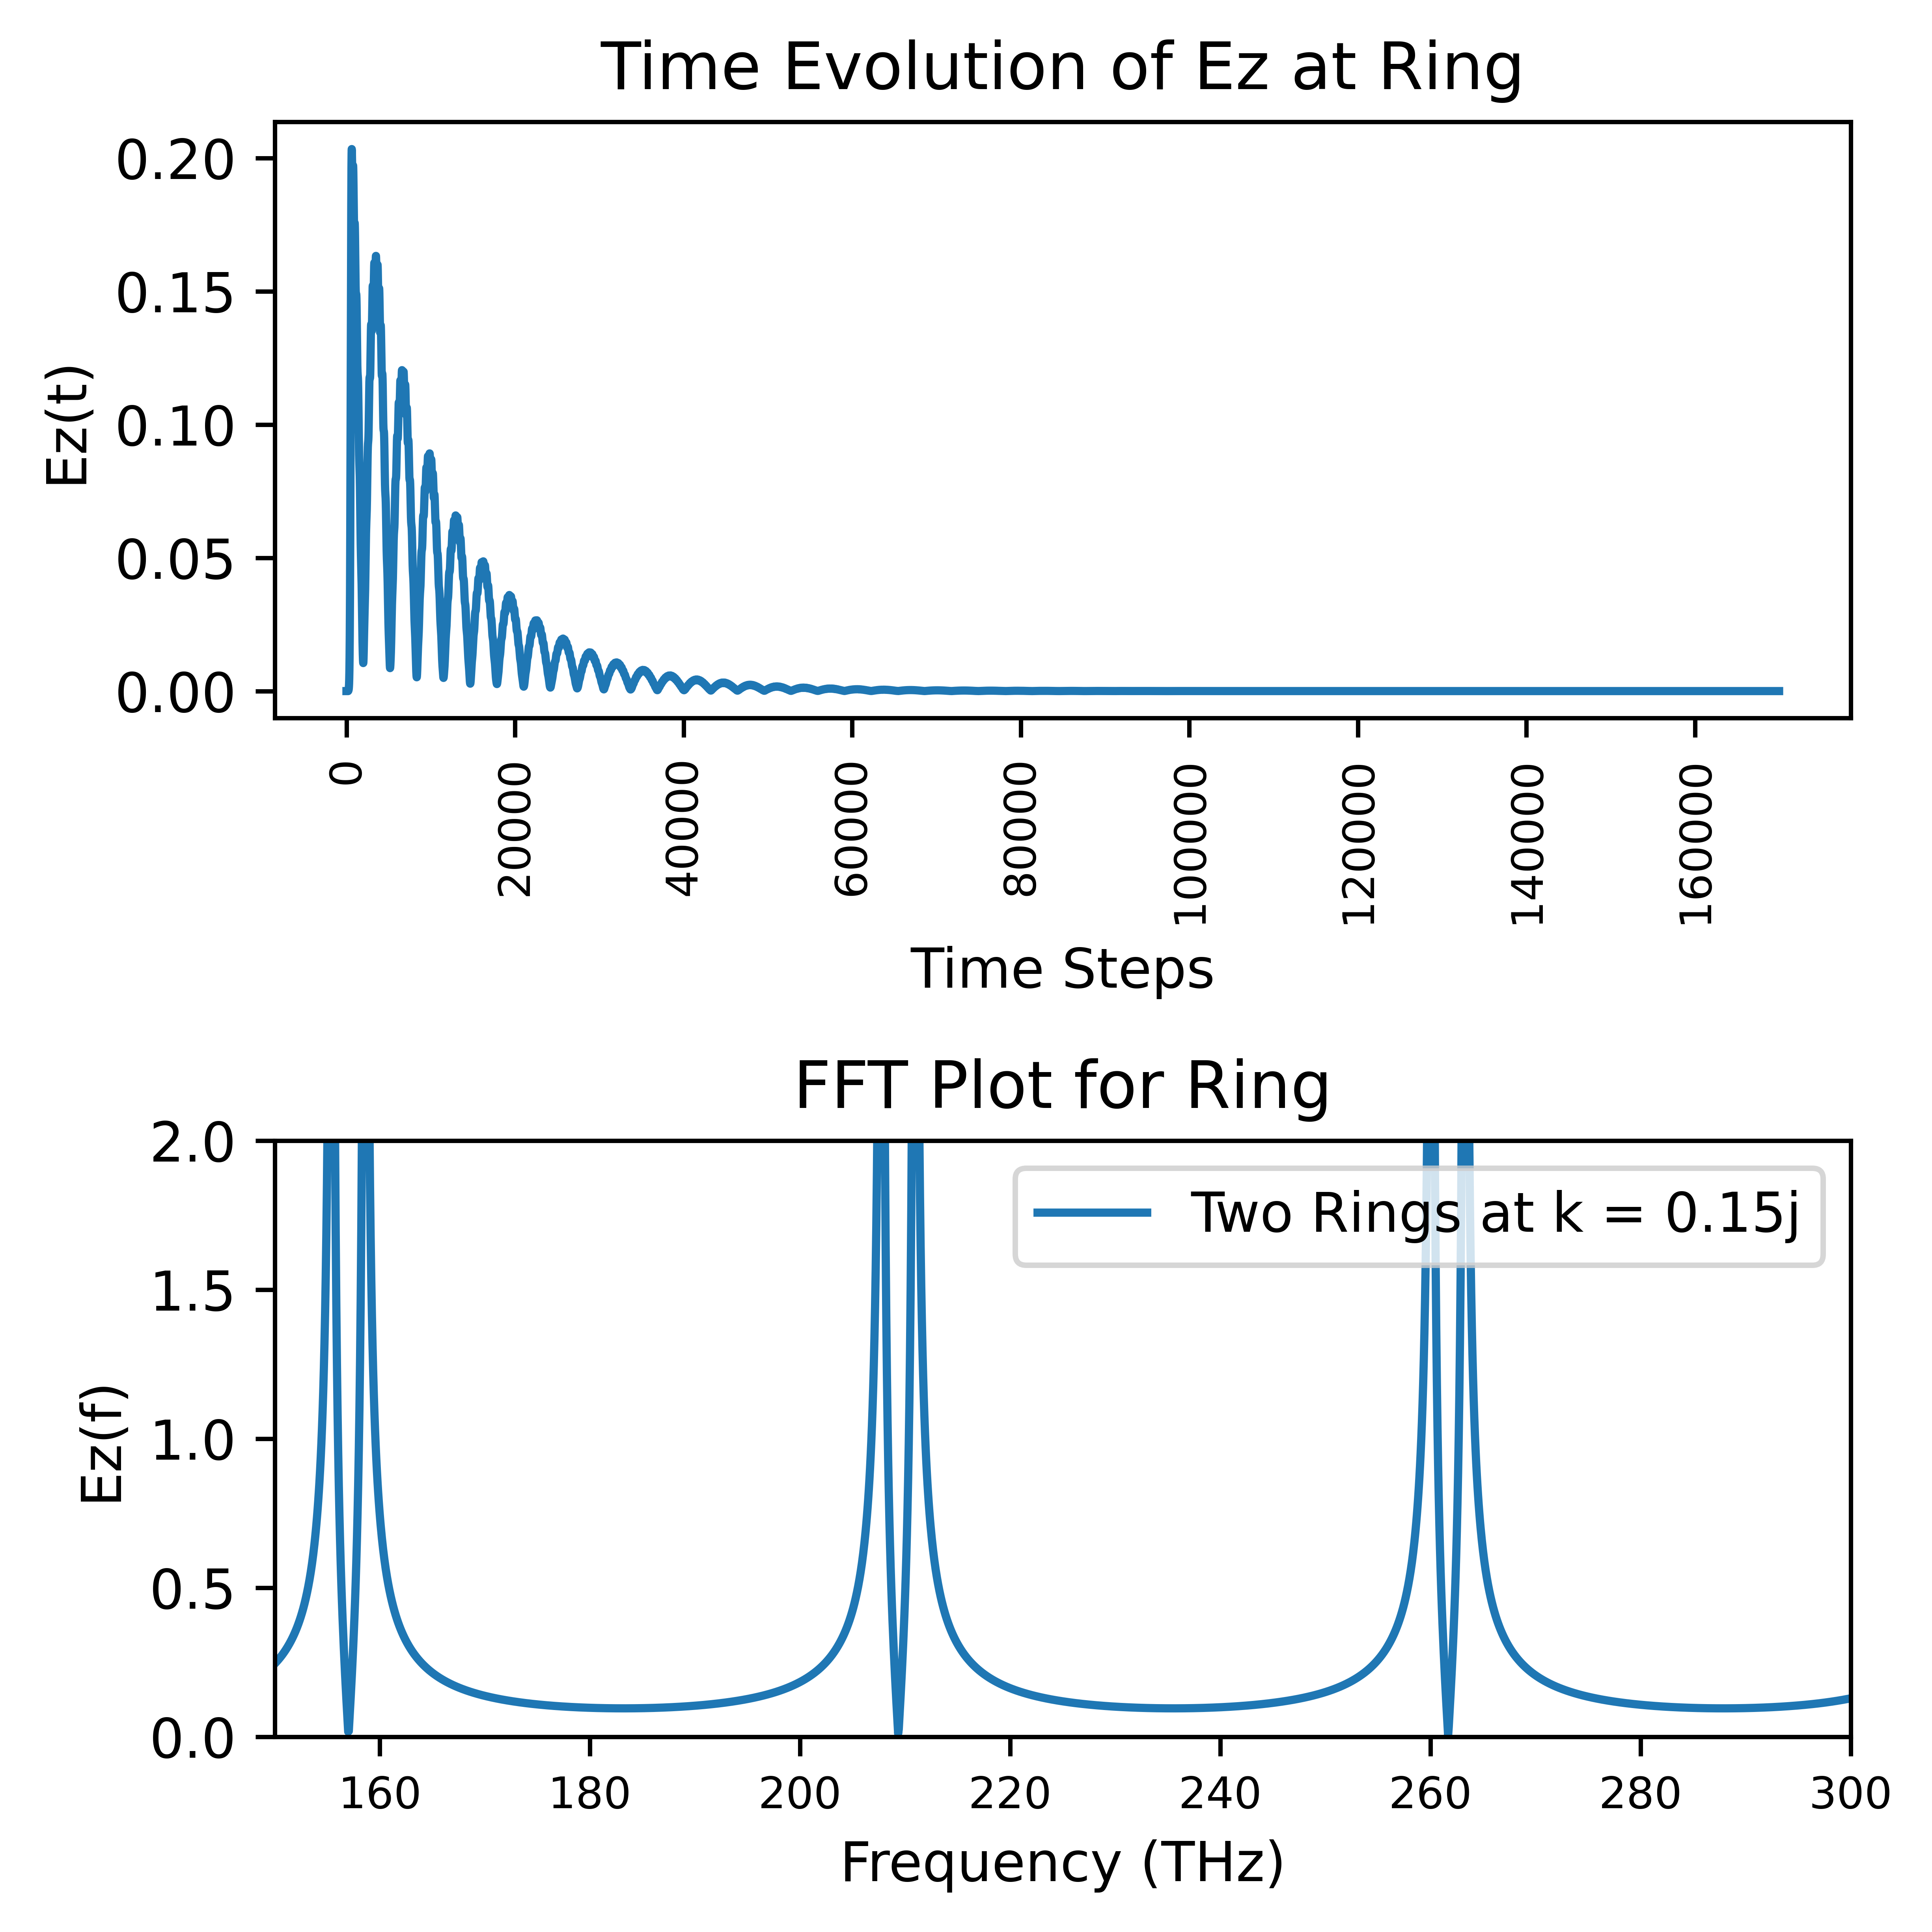

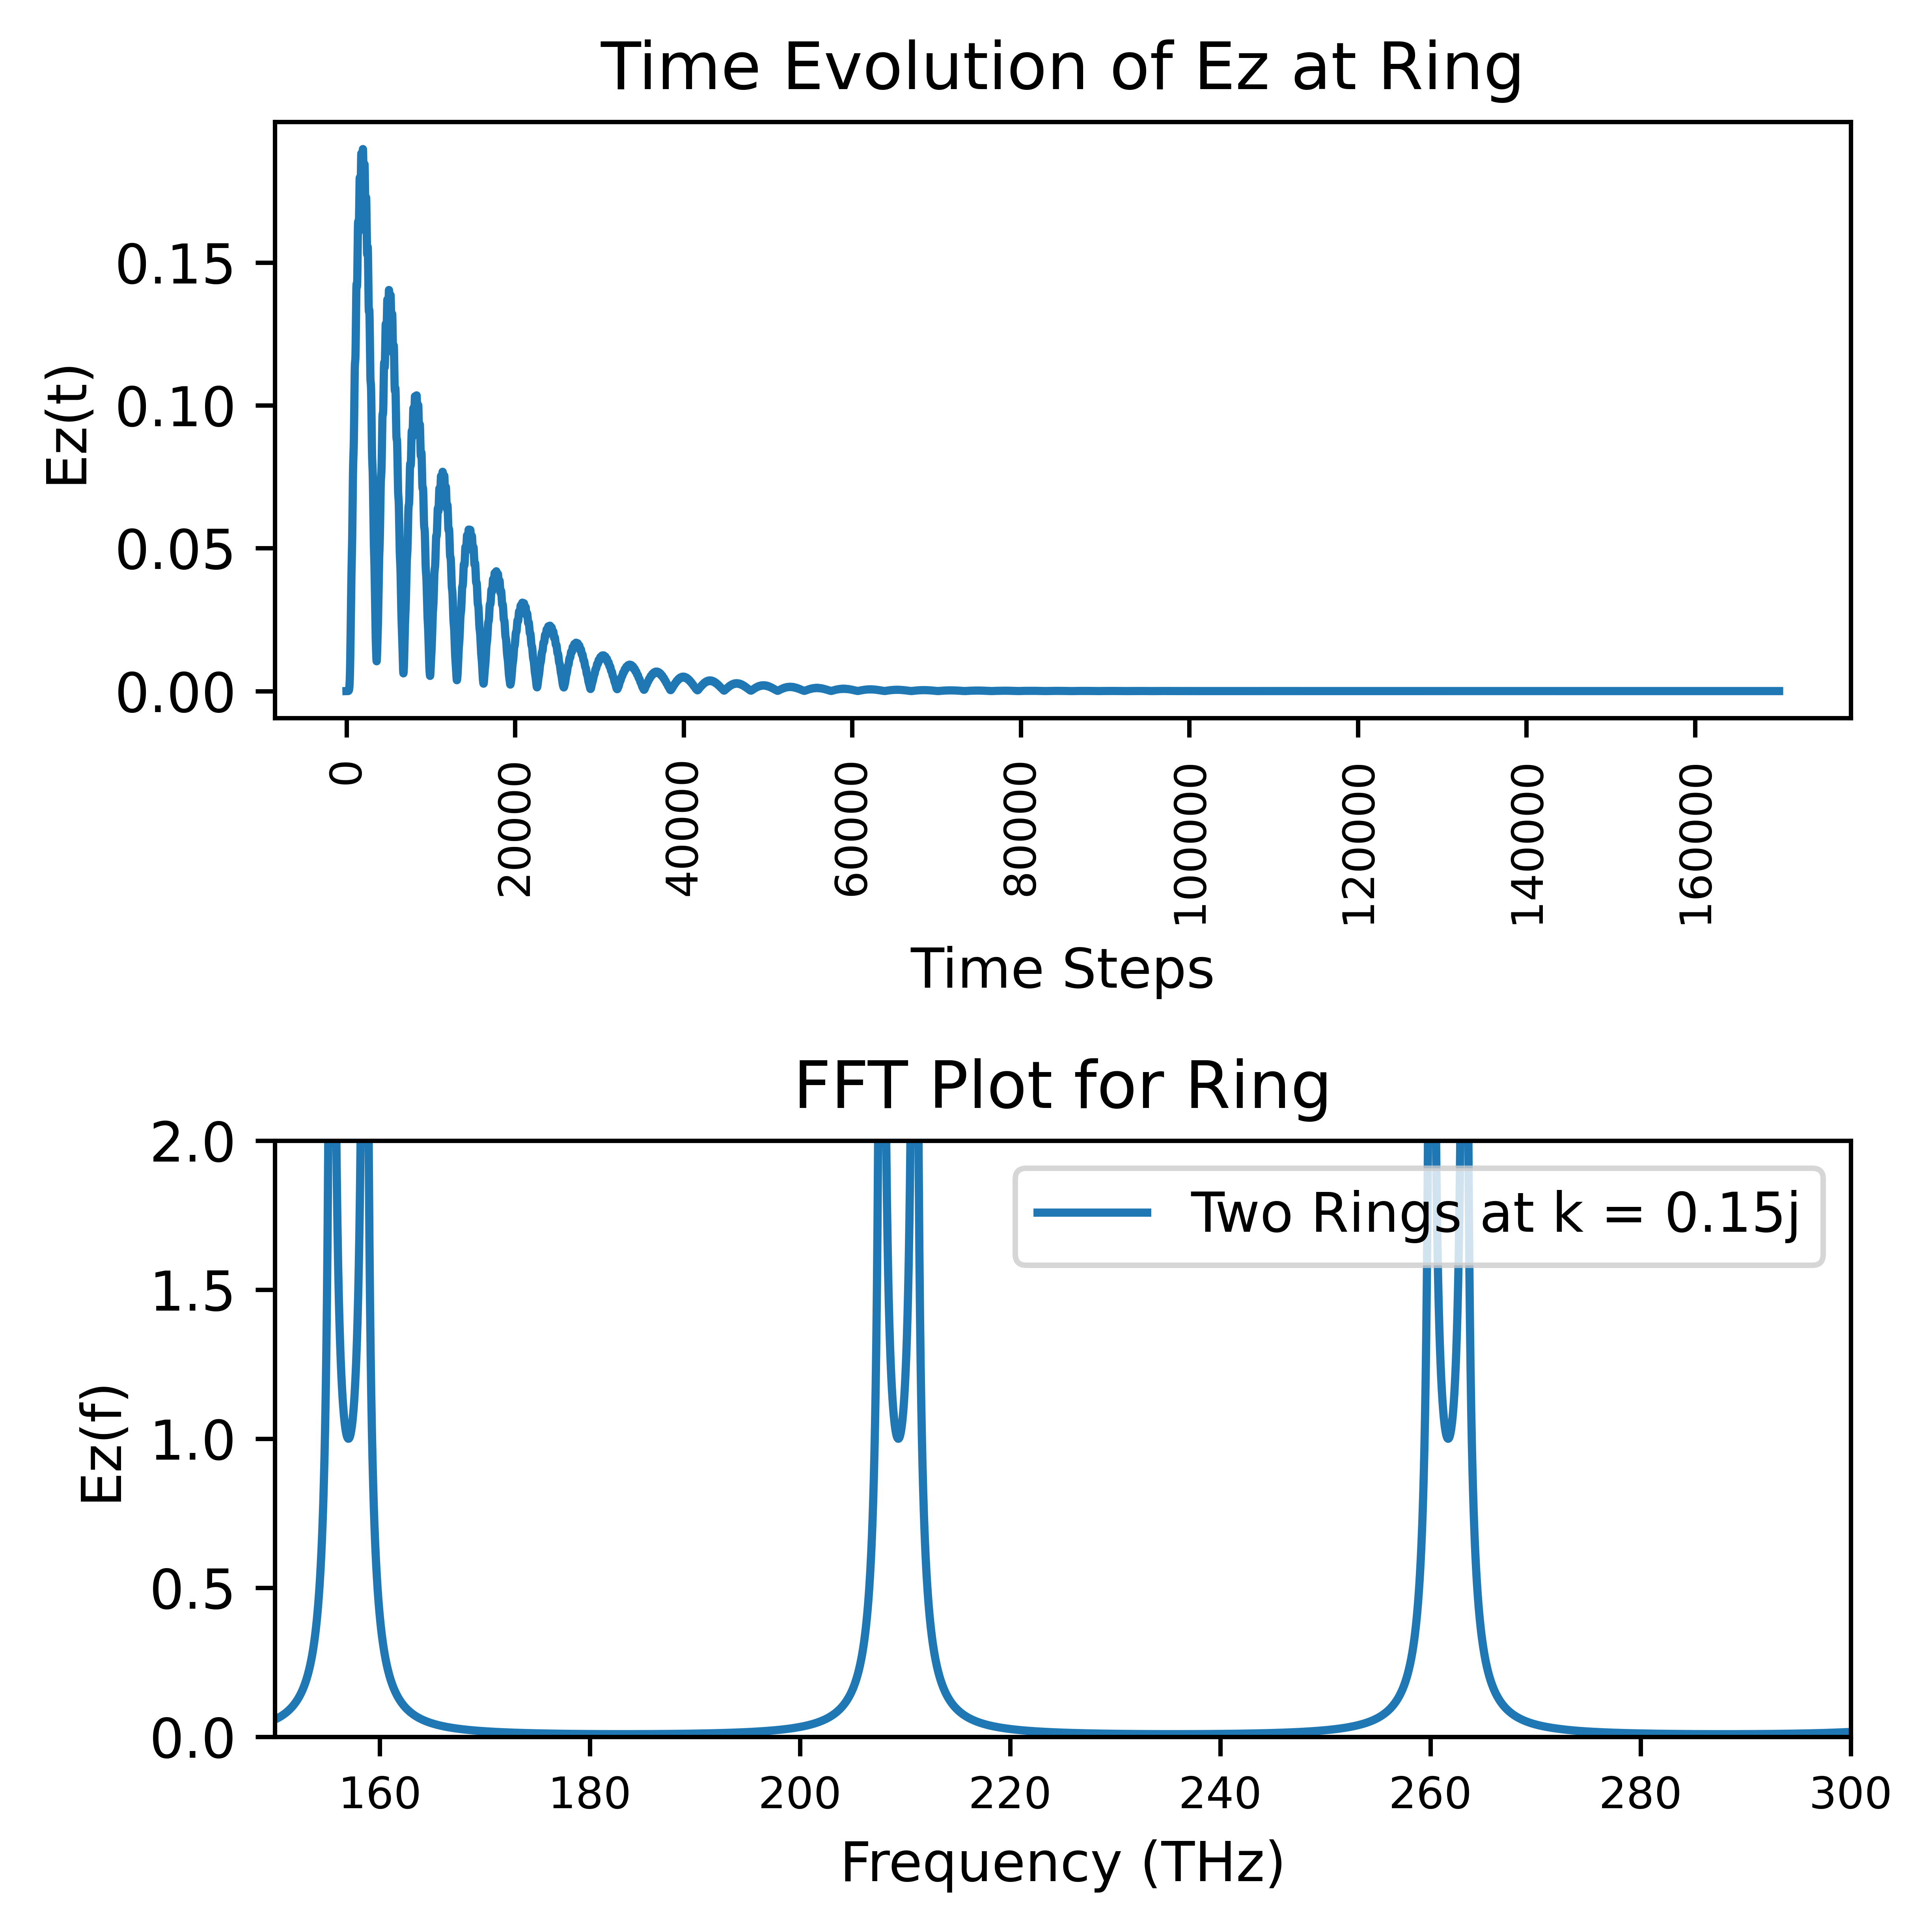

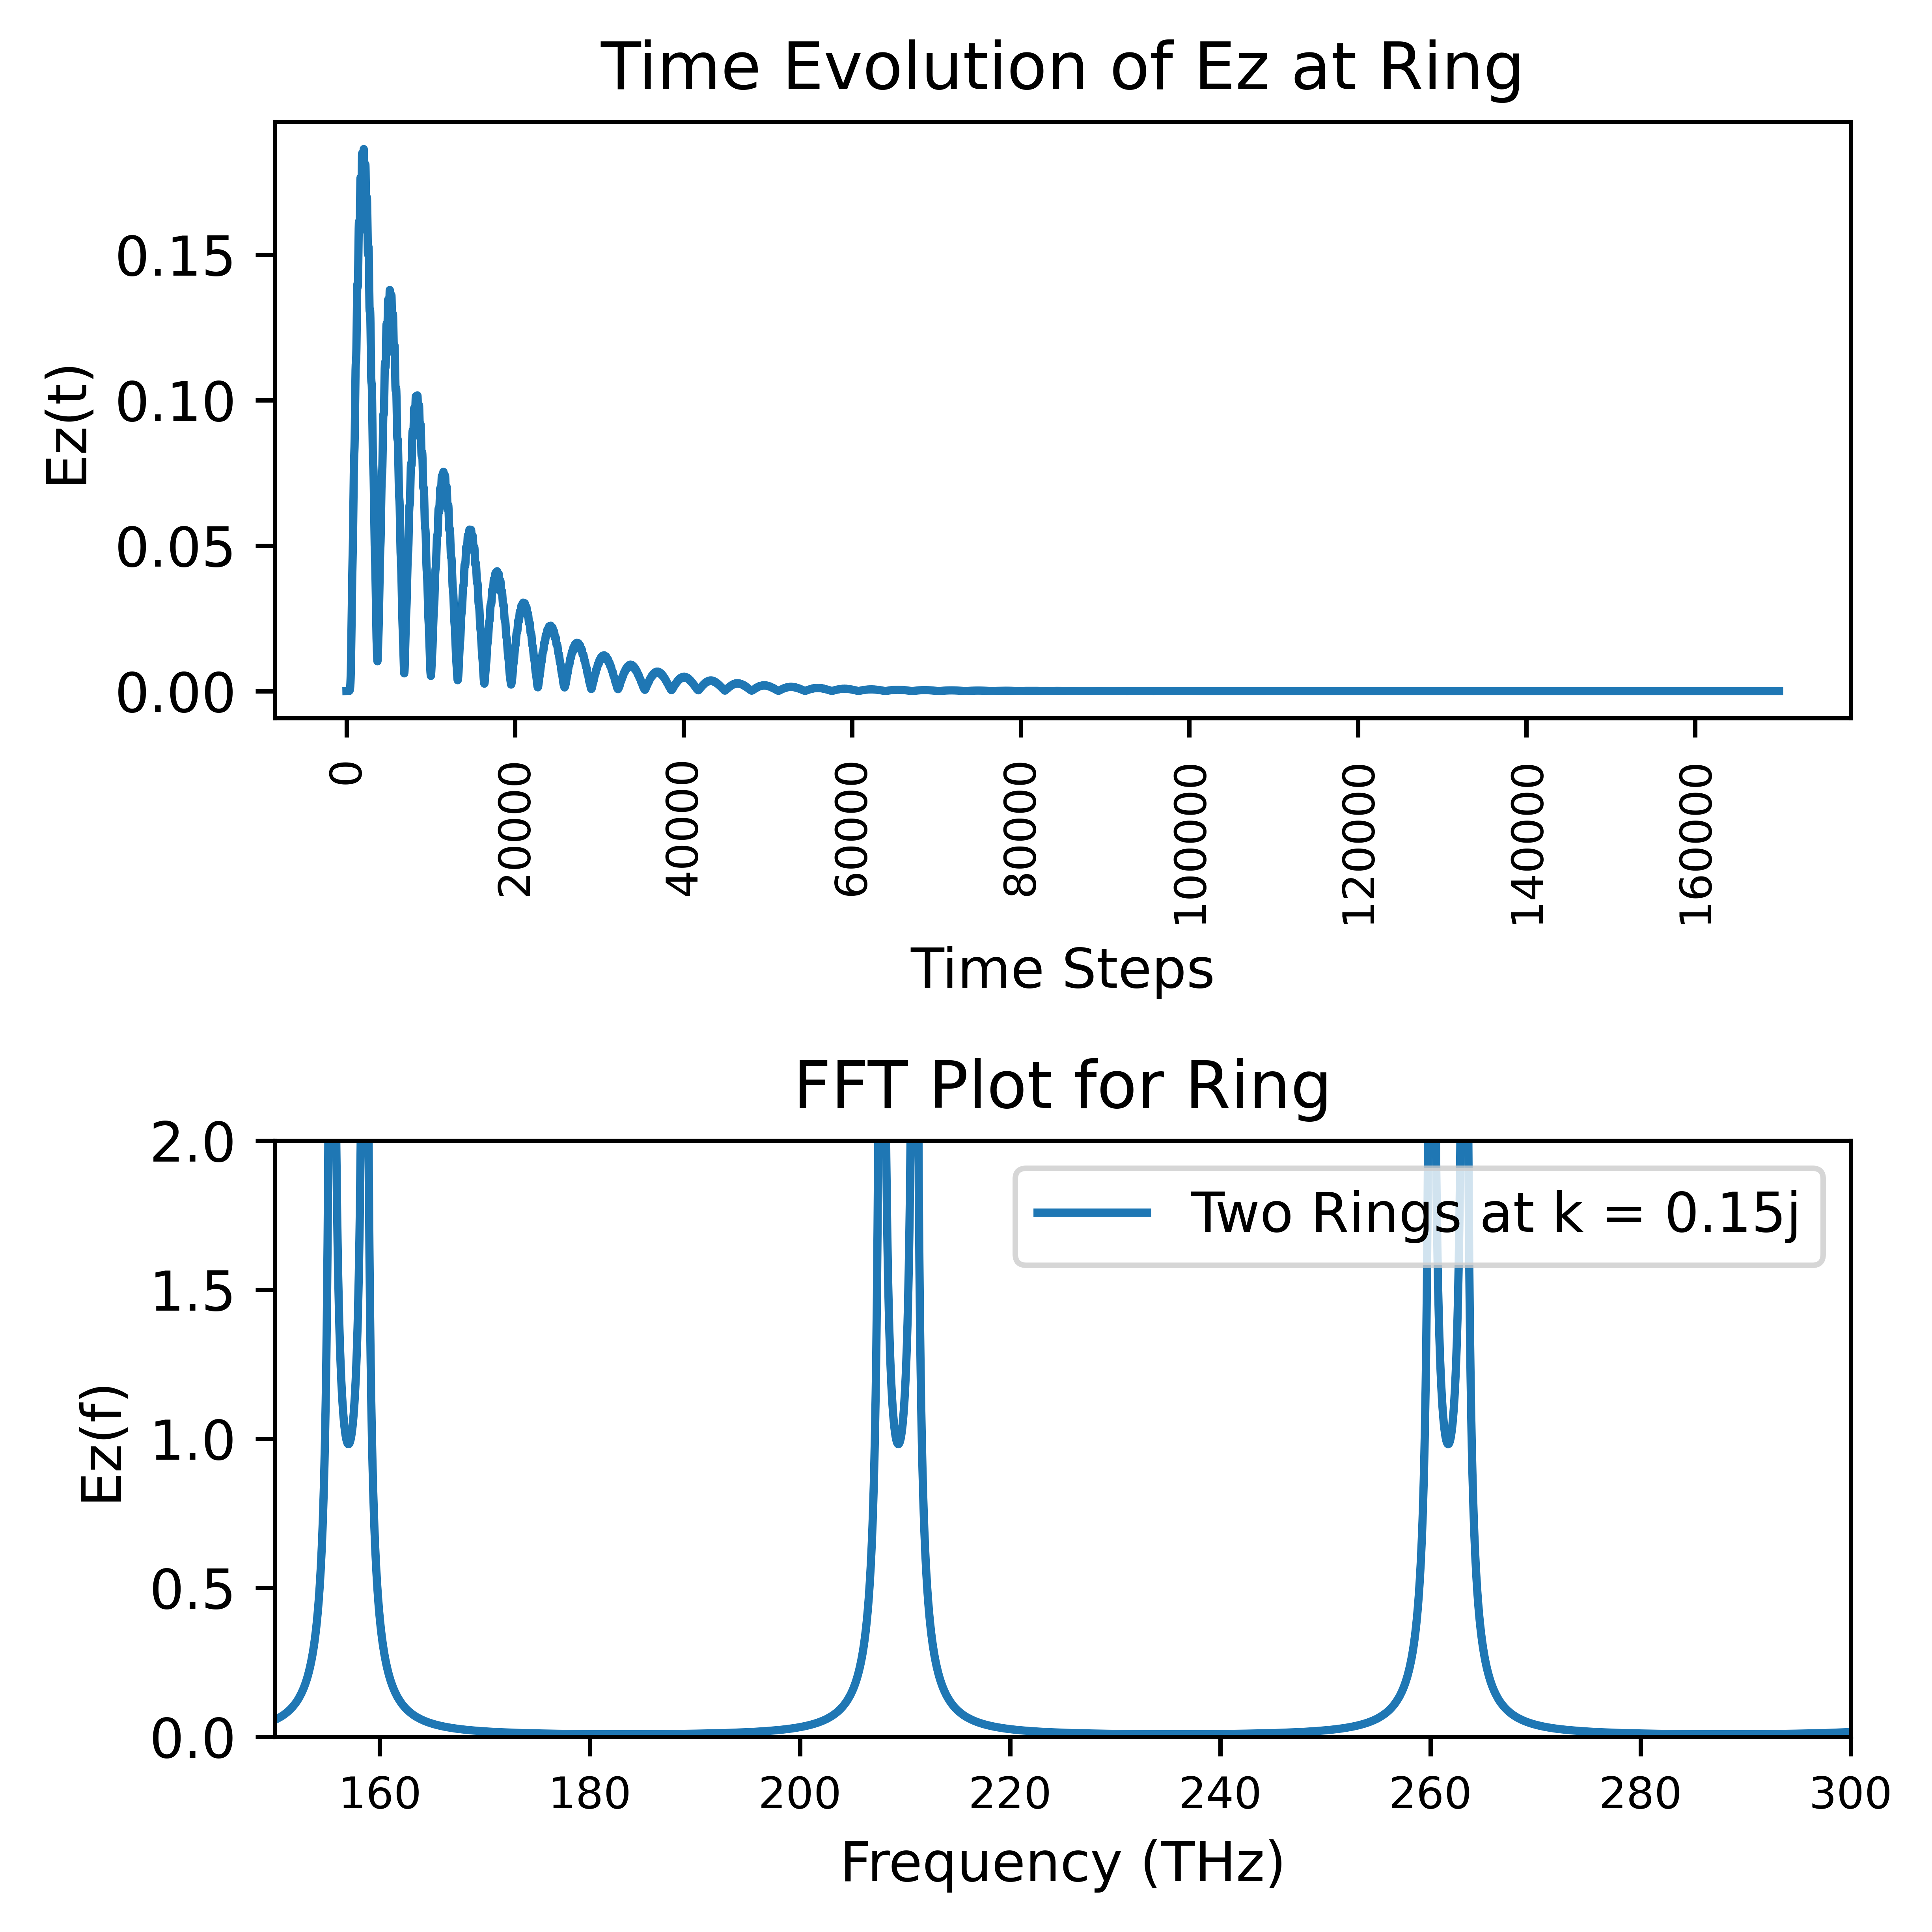

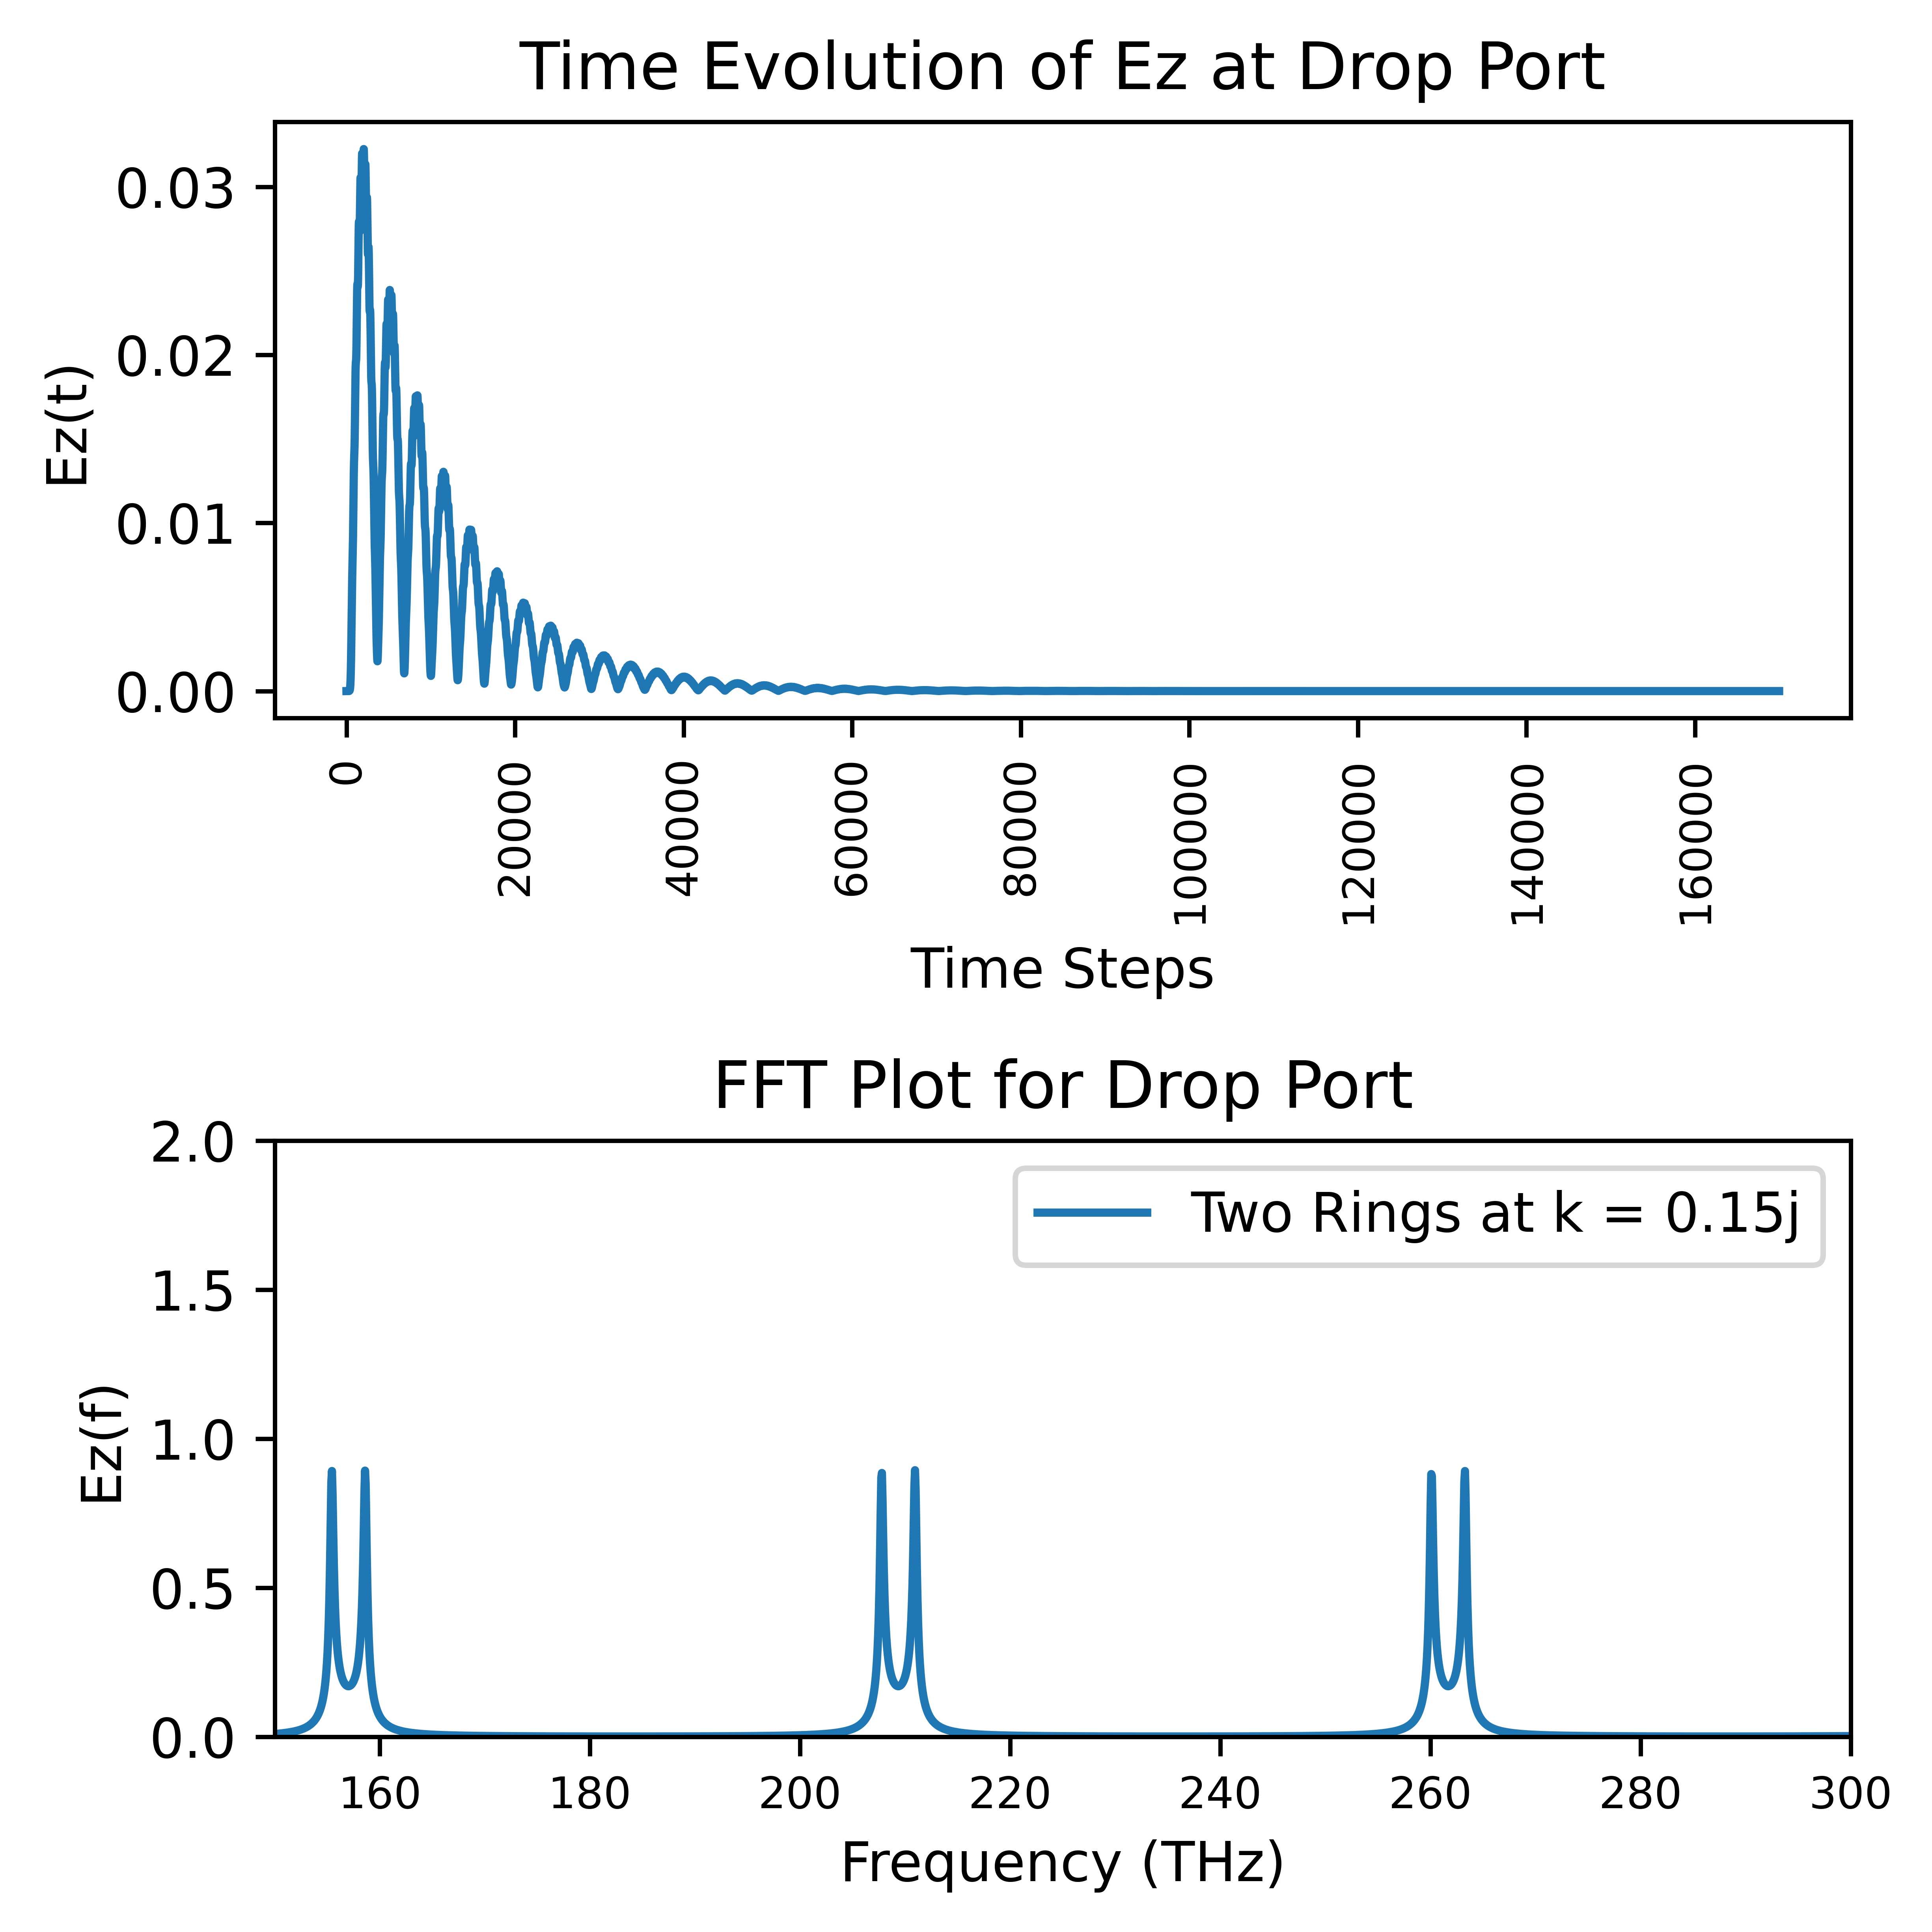

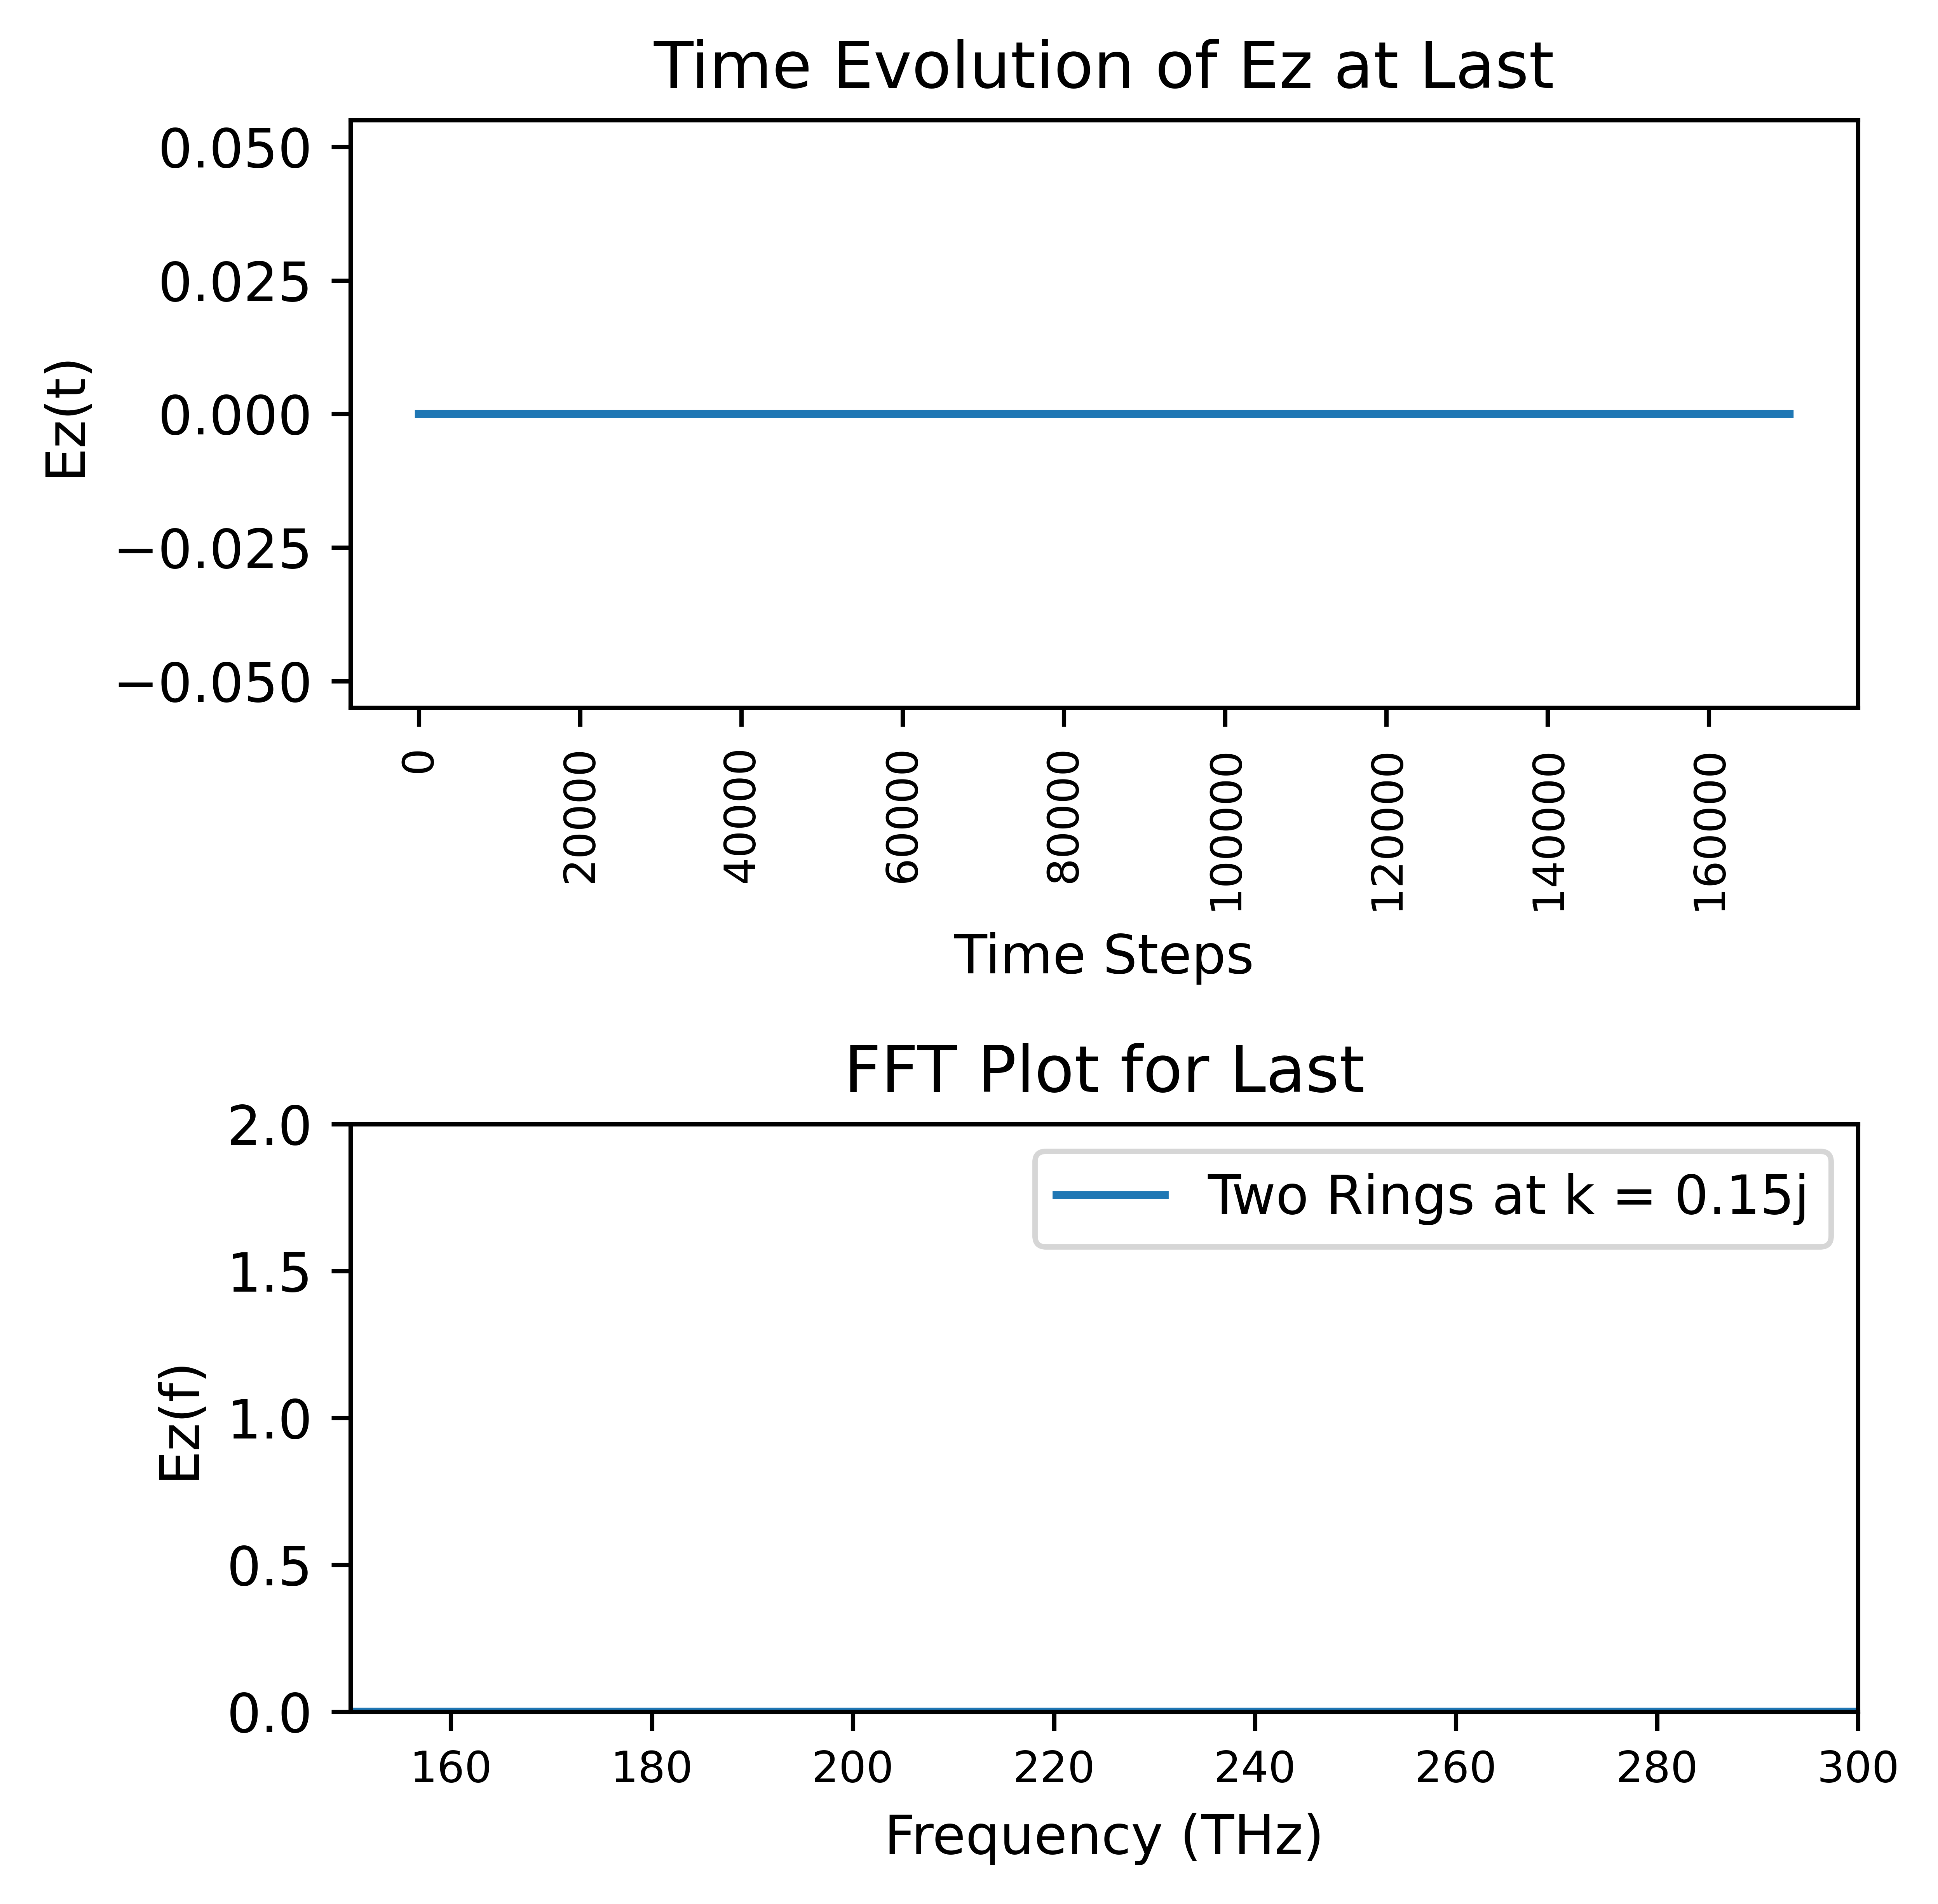

In [10]:
from cProfile import label
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
from numpy import linspace
from sympy import rotations
titles = ["Input Branch",
          "Through Port",
          "Ring",
          "Ring",
          "Ring",
          "Ring",
          "Drop Port",
          "Last"]

for ii in range(N_seg):
    # plt.figure(figsize=(5,5), dpi=1000)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5), dpi = 1000)

    # First subplot
    ax1.plot(np.abs(Ez[:, ii]), label="Two Rings")
    ax1.set_ylabel("Ez(t)")
    ax1.set_xlabel("Time Steps")

    # Integer ticks
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Rotate ticks safely
    ax1.tick_params(axis='x', rotation=90, labelsize = 8)
    # ax1.set_xticklabels(ax1.get_xticks(), rotation=90)
    # ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
    ax1.set_title(f"Time Evolution of Ez at {titles[ii]}")

    # Second subplot
    ax2.plot(freqs, np.abs(spectrum[:, ii]/ spectrum[:, 0]), label="Two Rings at k = 0.15j")
    ax2.set_xlim(1.5e14, 3e14)
    ax2.set_ylim(0,2)

    # Apply formatter here
    ax2.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
    )

    ax2.set_xlabel("Frequency (THz)")
    ax2.set_ylabel("Ez(f)")
    ax2.tick_params(axis='x', labelsize = 8)
    ax2.set_title(f"FFT Plot for {titles[ii]}")

    plt.tight_layout()
    plt.legend()
    plt.show()

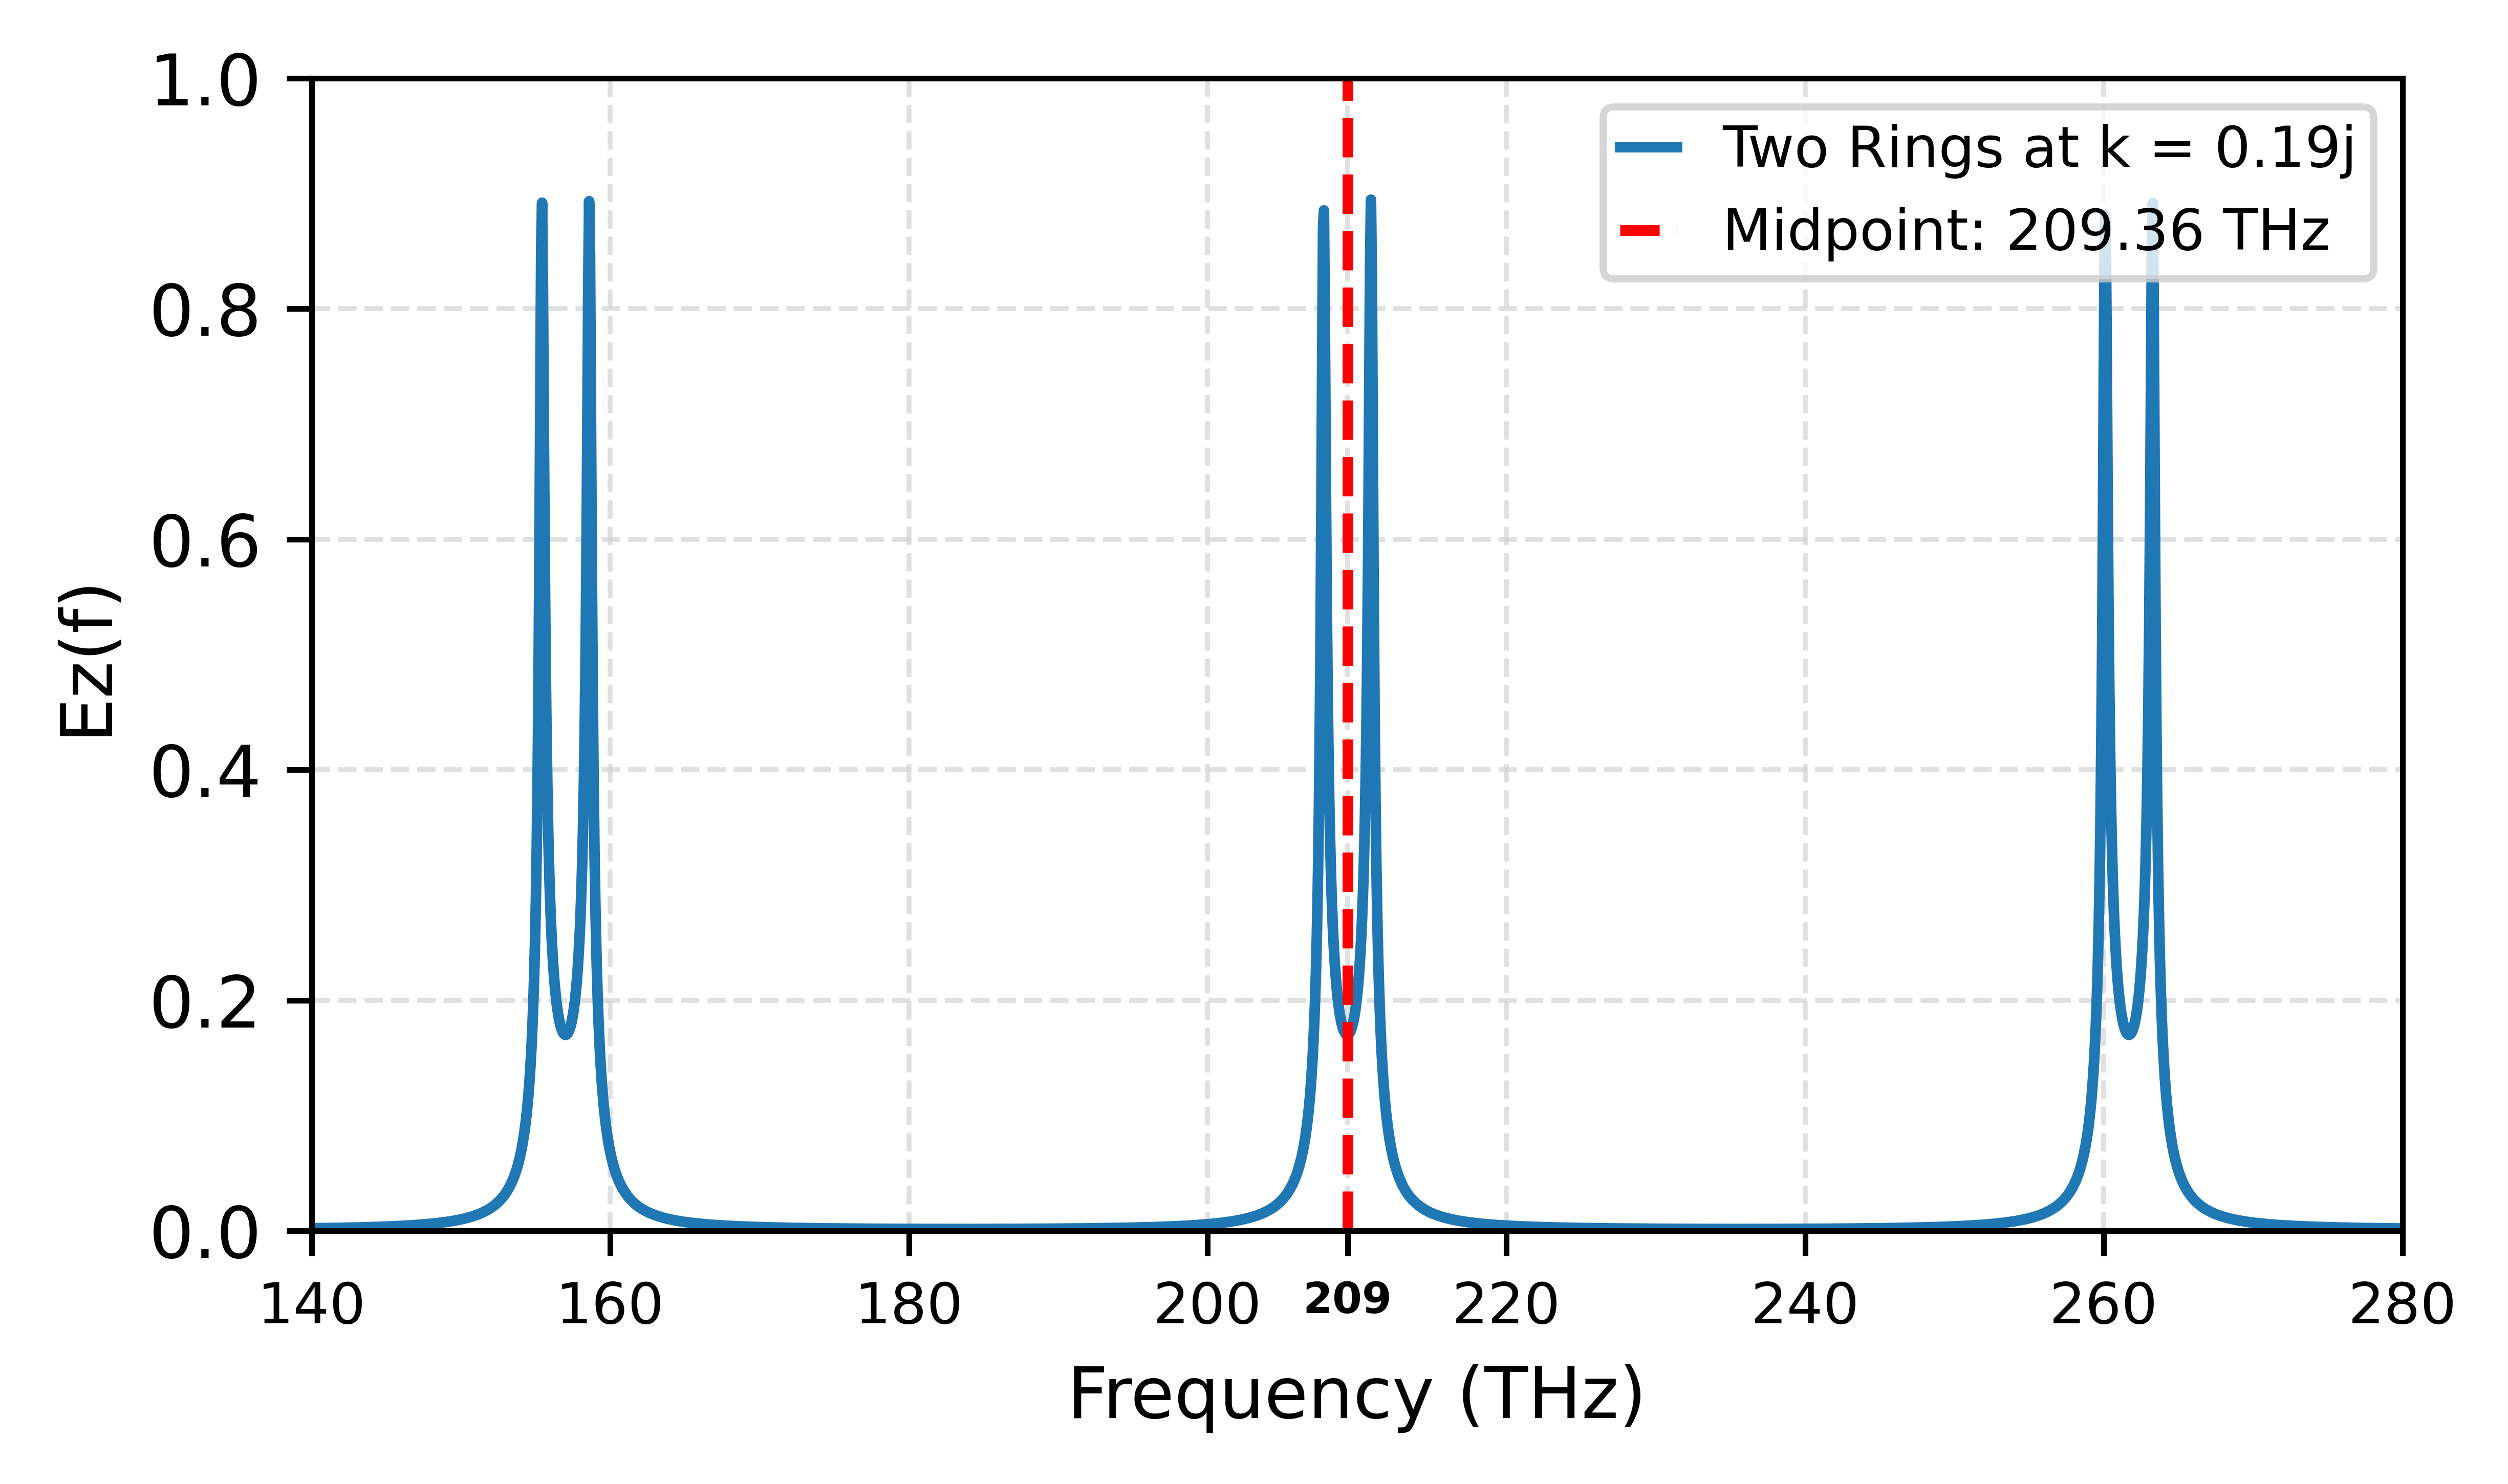

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks

fig, ax = plt.subplots(figsize=(5,3), dpi=1000)

# Drop port spectrum
drop_spectrum = np.abs(spectrum[:, N_seg-2] / spectrum[:, 0])
ax.plot(freqs, drop_spectrum, label="Two Rings at k = 0.19j")

ax.set_xlim(1.4e14, 2.75e14)
ax.set_ylim(0, 1.0)

# Apply formatter (Hz → THz)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
)

ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Ez(f)")
ax.tick_params(axis='x', labelsize=8)

# --- Find resonances (peaks) ---
peaks, _ = find_peaks(drop_spectrum, height=0.1)

if len(peaks) >= 9:
    f7 = freqs[peaks[7]]
    f8 = freqs[peaks[8]]
    mid_freq = (f7 + f8) / 2

    # Vertical line at midpoint
    ax.axvline(mid_freq, color='r', linestyle='--',
               label=f"Midpoint: {mid_freq/1e12:.2f} THz")

    # Add a tick at the midpoint
    xticks = list(ax.get_xticks()) + [mid_freq]
    ax.set_xticks(xticks)

    # Set default tick labels
    ax.set_xticklabels([f"{val/1e12:.0f}" for val in xticks], fontsize=8)

    # Make only the midpoint tick smaller + bold
    for label, val in zip(ax.get_xticklabels(), xticks):
        if np.isclose(val, mid_freq, rtol=1e-6):
            label.set_fontsize(6)       # smaller
            label.set_fontweight("bold")  # bolder

    ax.legend(fontsize=8, loc="best", frameon=True, borderpad=0.3, handlelength=1)
    ax.grid(True, color="lightgrey", linestyle="--", linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()



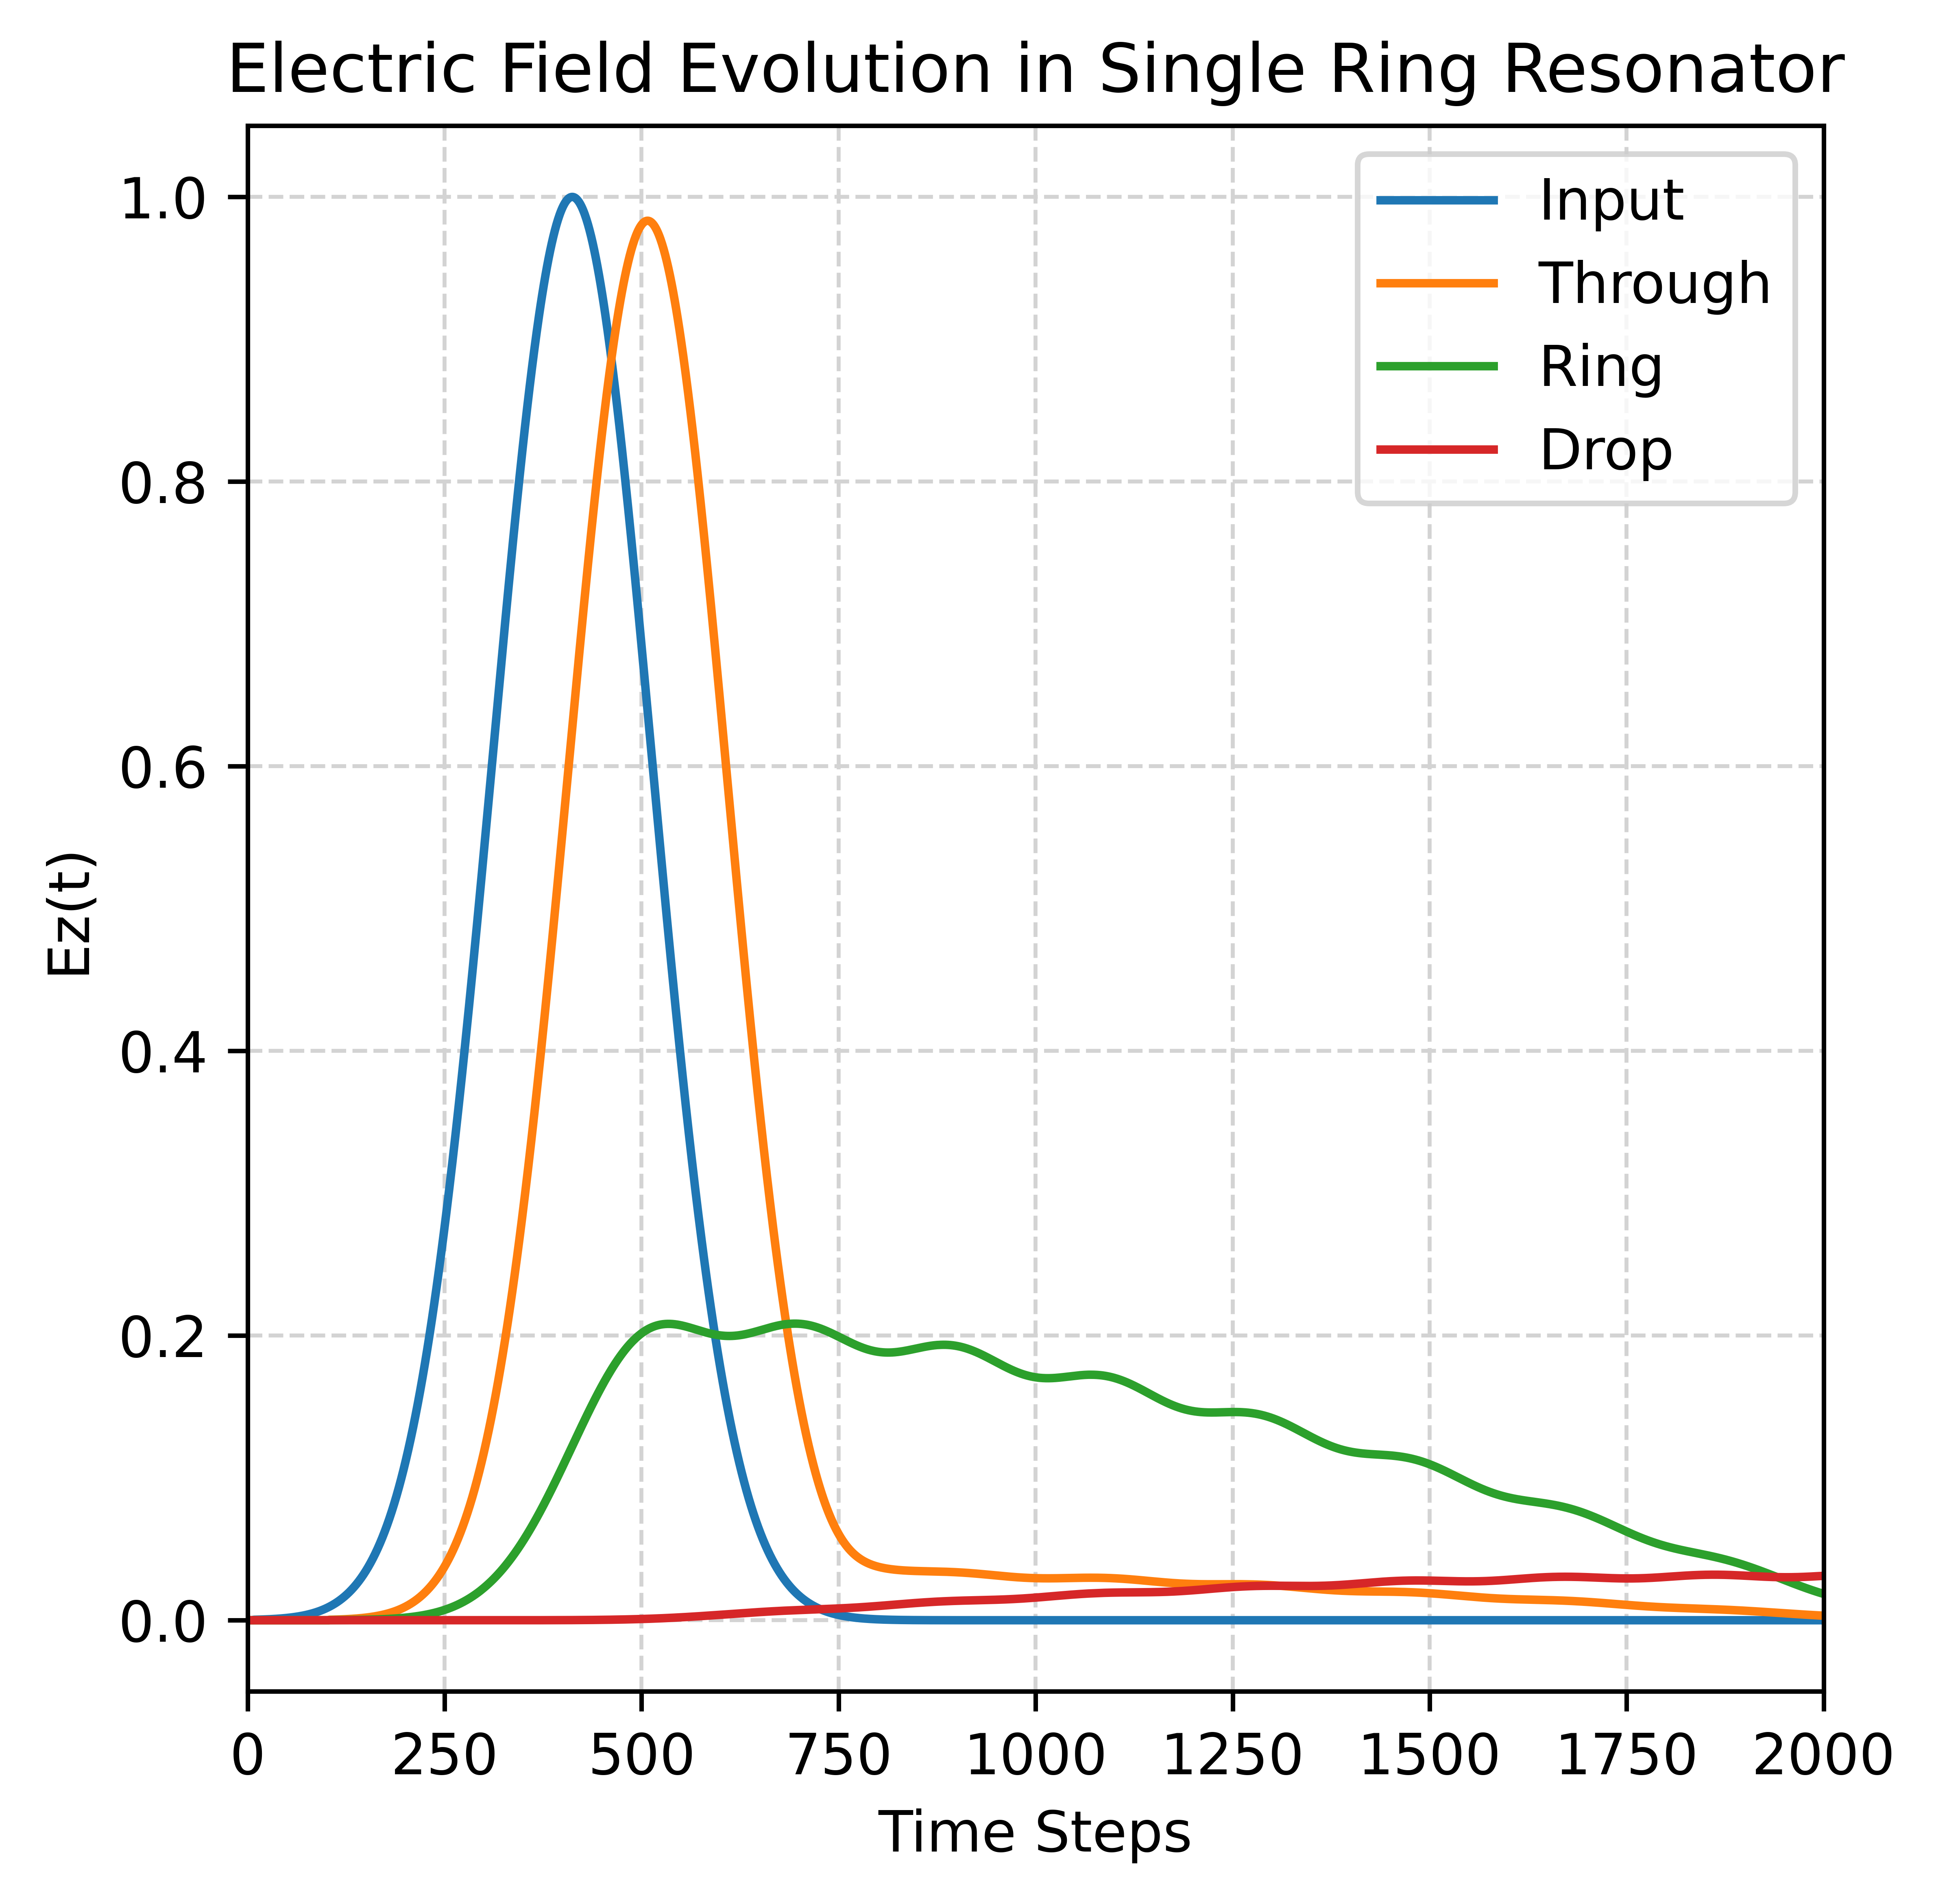

In [12]:
plt.figure(figsize=(5,5), dpi = 1000)
plt.plot(np.abs(Ez[:,0]), label="Input")
plt.plot(np.abs(Ez[:,1]), label="Through")
plt.plot(np.abs(Ez[:,2]), label="Ring")
plt.plot(np.abs(Ez[:,N_seg-2]), label="Drop")
plt.xlim(0,2000)
plt.title("Electric Field Evolution in Single Ring Resonator")
plt.xlabel("Time Steps")
plt.ylabel("Ez(t)")
plt.legend()
plt.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)
plt.show()

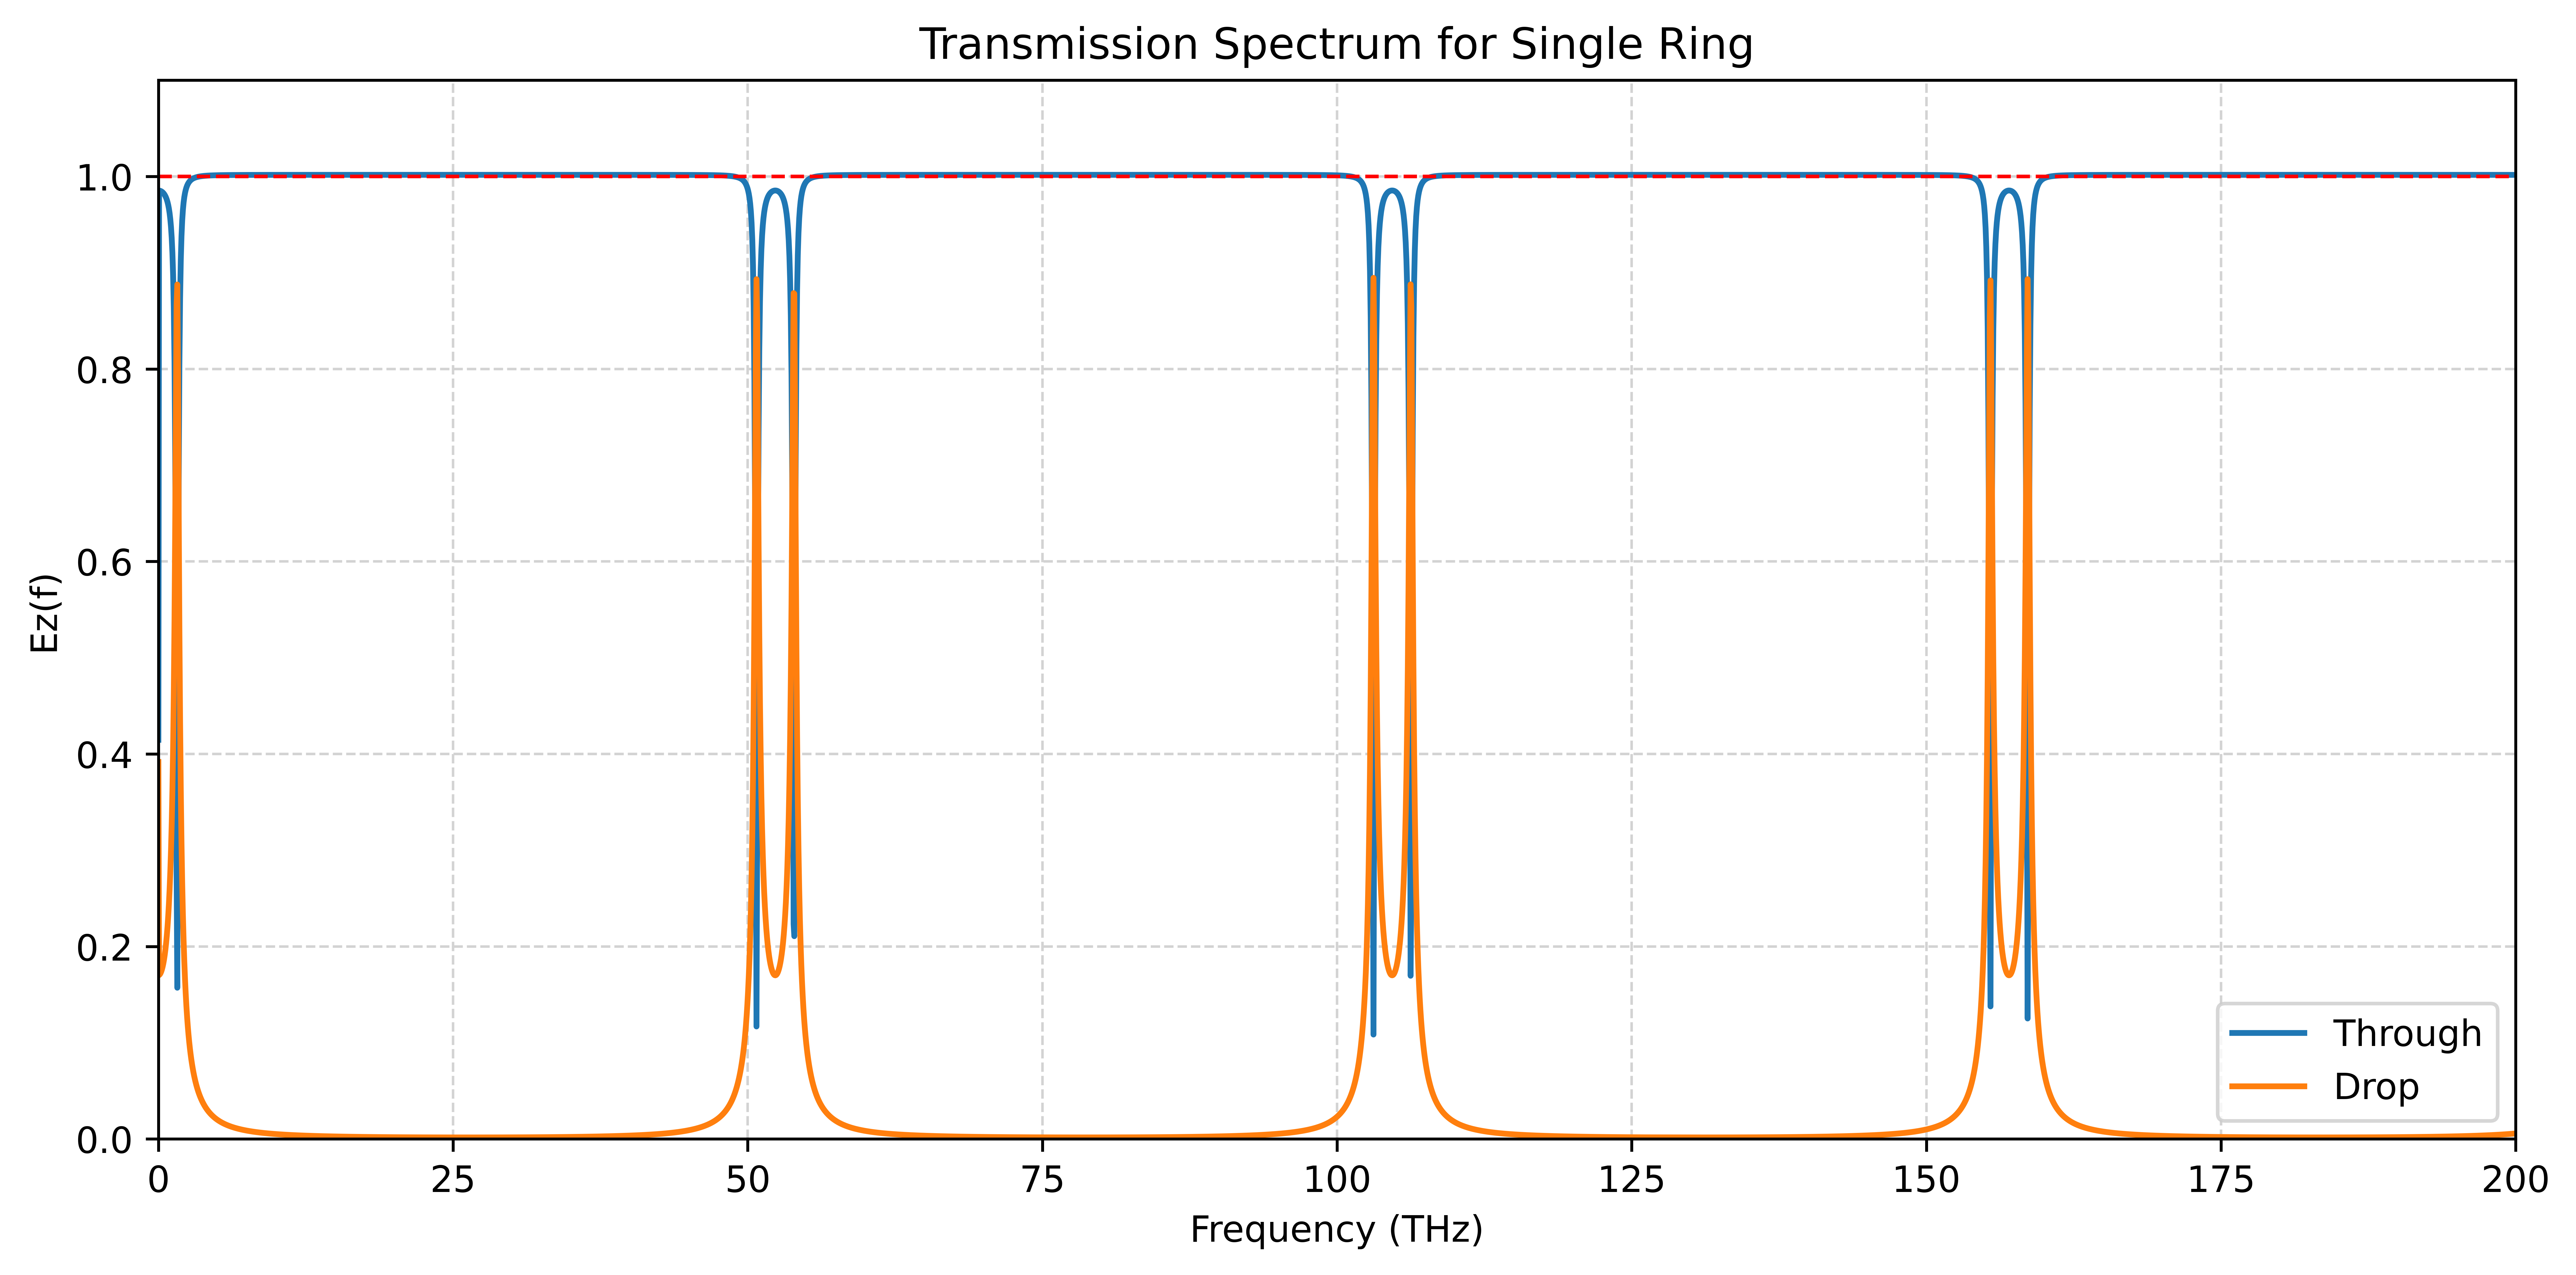

In [13]:

fig, ax = plt.subplots(figsize=(10, 5), dpi=1000)

ax.plot(freqs, np.abs(spectrum[:, 1] / spectrum[:, 0]), label="Through", linewidth = 1.6)
ax.plot(freqs, np.abs(spectrum[:, N_seg - 2] / spectrum[:, 0]), label="Drop", lw = 1.6)

ax.set_xlim(0, 2e14)
ax.set_ylim(0, 1.1)

# Horizontal line at y=1
ax.axhline(y=1, color='r', linestyle='--', linewidth=1)

# Apply formatter to x-axis (THz instead of Hz)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
)

ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Ez(f)")
ax.set_title("Transmission Spectrum for Single Ring")
ax.legend()
plt.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)


plt.tight_layout()
plt.show()


In [14]:
# from matplotlib.pyplot import subplots_adjust
# titles = ["Input Branch",
#           "Through Port",
#           "2",
#           "3",
#           "Drop Port",
#           "Last"]


# S_ref = np.fft.fftshift(np.fft.fft(Ez[:,0]))/N

# for ii in range(N_seg):
#     S_out = np.fft.fftshift(np.fft.fft(Ez[:,ii]))/N
#     H = S_out / (S_ref + 1e-30)  # avoid divide-by-zero

#     pos = freqs > 0
#     plt.figure(figsize=(5,5), dpi=1000)

#     # --- first subplot ---
#     ax1 = plt.subplot(2,1,1)
#     ax1.plot(np.abs(Ez[:,ii]), label=f"Probe {ii}")
#     # ax1.set_xlim(0, 20000)
#     ax1.set_title(f"Temporal Evolution of {titles[ii]}", fontsize=8)
#     ax1.set_xlabel("Time Steps", fontsize=8)
#     ax1.set_ylabel("Ez(t)", fontsize=8)
#     ax1.tick_params(labelsize=8)
#     ax1.legend()
#     ax1.grid(True, which="both", color="lightgrey", linestyle="--", linewidth=0.5, alpha=0.7)

#     # --- second subplot ---
#     ax2 = plt.subplot(2,1,2)
#     ax2.plot(freqs[pos]/1e12, 20*np.log10(np.abs(H[pos])), label=f"Probe {ii}")
#     ax2.set_xlim(150, 250)
#     ax2.xaxis.set_major_formatter(
#         ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
#     )
#     ax2.set_title(f"FFT Spectrum of {titles[ii]}", fontsize=8)
#     ax2.set_xlabel("Frequency (THz)", fontsize=8)
#     ax2.set_ylabel("Ez(f)", fontsize=8)
#     ax2.tick_params(labelsize=8)
#     ax2.legend()
#     ax2.grid(True, which="both", color="lightgrey", linestyle="--", linewidth=0.5, alpha=0.7)

#     # --- adjust subplot spacing ---
#     plt.subplots_adjust(hspace=0.5)

#     plt.show()

In [15]:
# # ref_s: Ez recorded at a reference probe near the source (same length as s3)
# S_out = np.fft.fftshift(np.fft.fft(Ez[:,1]))/N
# S_ref = np.fft.fftshift(np.fft.fft(Ez[:,0]))/N
# H = S_out / (S_ref + 1e-30)  # avoid divide-by-zero

# # Plot only positive freqs (complex source -> one-sided)
# pos = freqs > 0
# plt.figure(figsize=(8,4))
# plt.plot(freqs[pos]/1e12, 20*np.log10(np.abs(H[pos])/np.max(np.abs(H[pos]))))
# plt.xlim(150, 250)
# plt.xlabel("Frequency (THz)"); plt.ylabel("|H(f)| (dB, normalized)")
# plt.title("Ring Transfer (through/drop)")
# plt.grid(True, alpha=0.3)
# plt.show()


In [16]:
# pos = freqs>0
# plt.plot(freqs[pos]/1e12,(np.abs(S_ref[pos])))
# plt.xlim(150, 250)  
# # plt.plot(freqs, S_ref)

In [17]:
from scipy.signal import find_peaks

res_freq = []
signal = spectrum[:,1] #taking the through port

peaks, _ = find_peaks(signal)

res_freq = freqs[peaks]/1e12

# # Example: take one probe (say ii=0)
# spec = np.abs(spectrum[:, 1])
# spec /= np.max(spec)  # normalize

# # find peaks above 10% of max, with min spacing
# peaks, _ = find_peaks(spec, height=0.1, distance=10)

# # Extract resonant freqs in Hz
# resonant_freqs = freqs[peaks]

# # Convert to THz for readability
# resonant_freqs_THz = resonant_freqs / 1e12

print("Resonant frequencies (THz):", res_freq)


Resonant frequencies (THz): [1.78254168e-01 4.93169865e+01 5.25255615e+01 1.01723712e+02
 1.04932287e+02 1.20559236e+02 1.54962290e+02 1.58052029e+02
 2.00001176e+02 2.08676213e+02 2.11647115e+02 2.60548176e+02
 2.63697333e+02 2.79443117e+02 3.13786754e+02 3.16995329e+02
 3.66193479e+02 3.69402054e+02 4.18540786e+02 4.21868198e+02
 4.70888094e+02 4.74274923e+02 5.23235401e+02 5.26681648e+02
 5.75582708e+02 5.79088374e+02 6.27930016e+02 6.31495099e+02
 6.80277323e+02 6.83901824e+02 7.32624630e+02 7.36308550e+02
 7.84971938e+02 7.88715275e+02 8.37319245e+02 8.41062583e+02
 8.89666552e+02 8.93469308e+02 9.42013860e+02 9.45876033e+02
 9.94361167e+02 9.98223341e+02 1.04670847e+03 1.05063007e+03
 1.09905578e+03 1.10297737e+03 1.15134367e+03 1.15538410e+03
 1.20369098e+03 1.20773141e+03 1.25603829e+03 1.26013813e+03
 1.30838559e+03 1.31248544e+03 1.36073290e+03 1.36489216e+03
 1.41308021e+03 1.41723947e+03 1.46542751e+03 1.46964620e+03
 1.51771540e+03 1.52199350e+03 1.57006271e+03 1.57440023e

(8, 170000, 100)
8


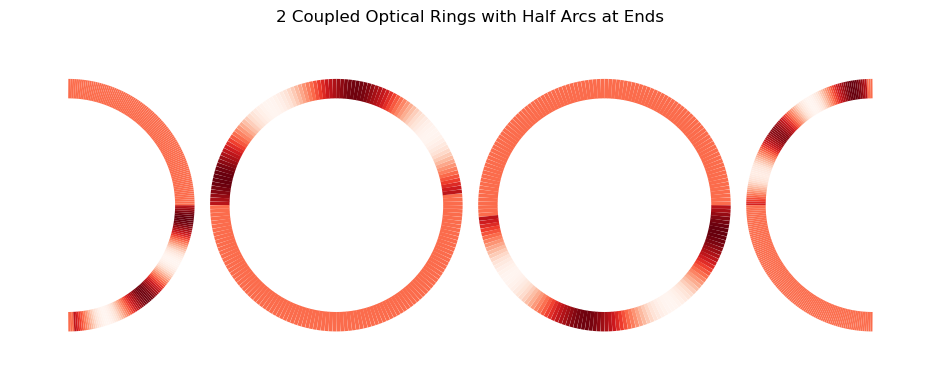

8


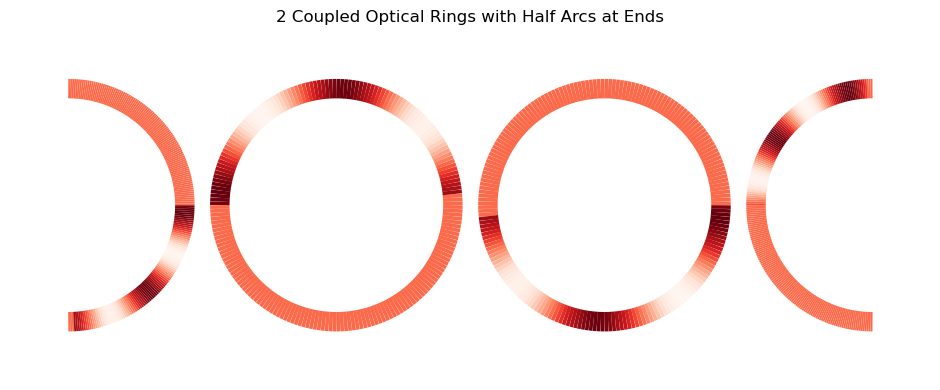

8


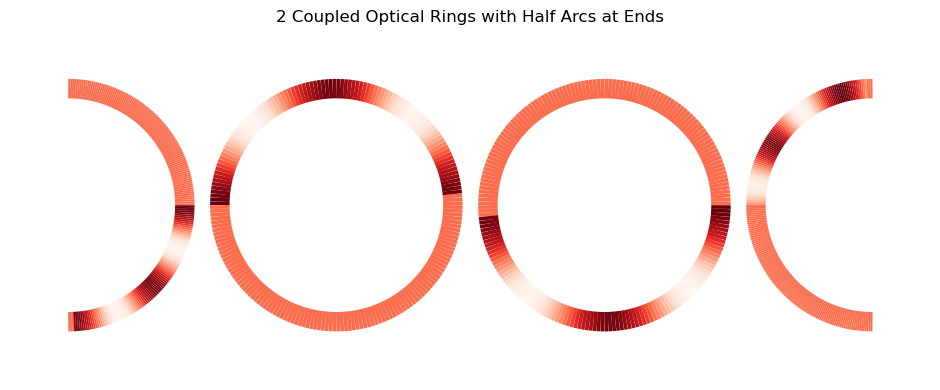

8


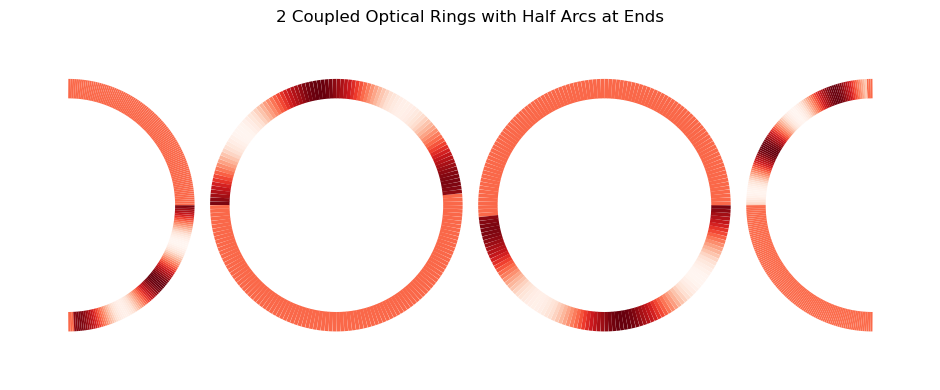

8


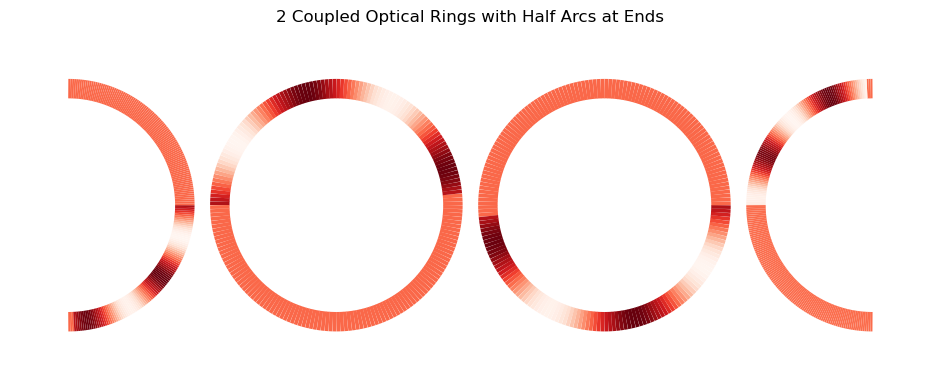

8


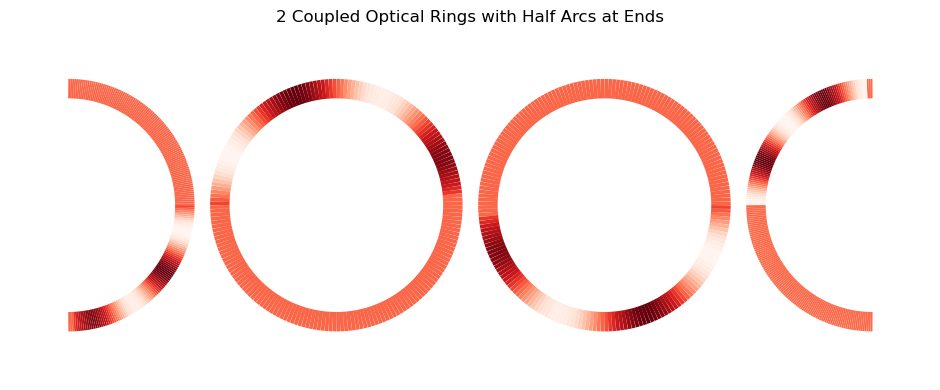

8


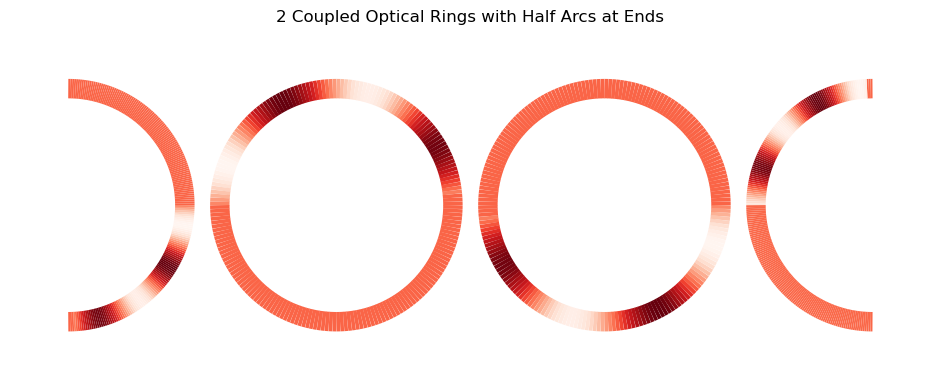

8


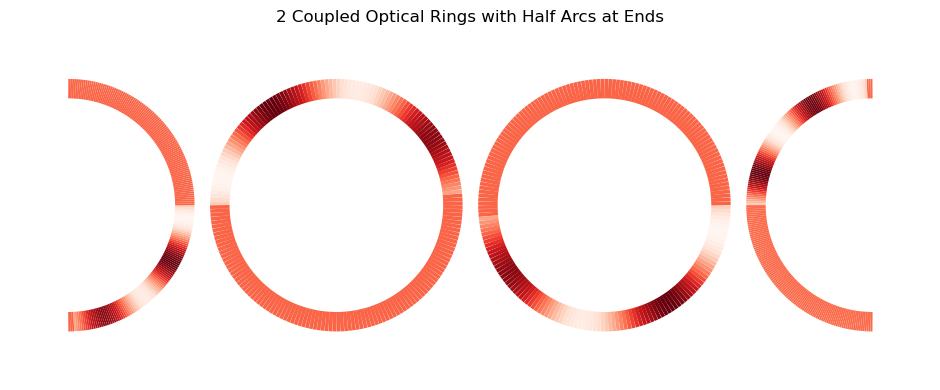

8


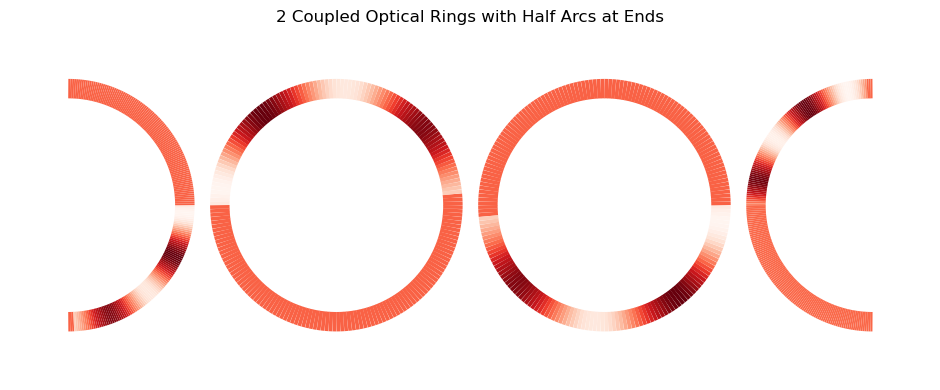

8


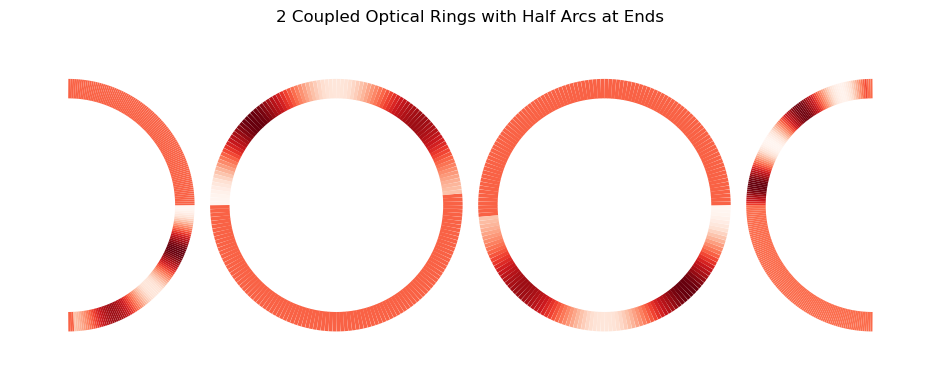

In [18]:
# Parameters
ez_tab_ordered = np.zeros((N_seg, maxTime, SIZE), dtype = complex)
for ring in range(rings_no):
    if ring%2 == 0: #even segment
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring + 1,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring,:,:]
    else:
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring + 1,:,:]
        
print(np.shape(ez_tab_ordered))


for tp in range(1000,2000,100):
    ez_tab_tp = ez_tab_ordered[:,tp,:]      
    plot_field_ring(ez_tab_tp, rings_no)

In [19]:
#while coupling I used different indices so in order for the arc plotting function to stack the electric fields in the order they were coupled, I made this logic.

for ring in range(rings_no):
    if ring%2 ==0:
        print(2*ring, 2*ring +1)
        print(2*ring+1, 2*ring)
    else:
        print(2*ring, 2*ring +1)
        print(2*ring, 2*ring +1)

0 1
1 0
2 3
2 3
4 5
5 4
6 7
6 7
